<a id='start'></a>
# Проект: Обучение с учителем: качество модели

**Описание проекта:**  
Интернет-магазин «В один клик» хочет продолжать удерживать активность постоянных клиентов с помощью персонализированных предложений. Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.  
**Цель проекта:**  
Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.  
**Задачи:**  
* [Изучить и подготовить данные](#download)
* [Провести предобработку данных](#preprocessing)
* [Провести исследователький анализ данных](#research)
* [Провести объединение данных](#merge)
* [Провести корреляционный анализ данных](#corr)
* [Разработать модели для предсказания активности клиентов](#models)
* [Провести анализ важности признаков модели](#importance)
* [Провести анализ сегментов пользователей](#segment)
* [Предоставить вывод по проделанной работе](#conclusion)

<a id='download'></a>
## [Загрузка данных](#start)

**Для корректной работы проекта были установлены:**
* Обновление sklearn
* Модуль shap
* matplotlib версии 3.7.0

In [79]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: julynter 0.4.2 has a non-standard dependency specifier jupyter-server<2requests,>=1.6. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of julynter or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [80]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: julynter 0.4.2 has a non-standard dependency specifier jupyter-server<2requests,>=1.6. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of julynter or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [81]:
pip install matplotlib==3.7.0 -q

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: julynter 0.4.2 has a non-standard dependency specifier jupyter-server<2requests,>=1.6. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of julynter or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
# Импортируем необходимые библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [5]:
# Загружаем данные и просматриваем первичную информацию
market_file = pd.read_csv('datasets/market_file.csv')
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
# Приводит названия колонок к "змеинному регистру"
market_file_col = market_file.columns.tolist()
for i in range(len(market_file_col)):
    market_file_col[i] = market_file_col[i].lower().replace(' ', '_')
# Меняем названия колонок в датасете
market_file.columns = market_file_col
# Снова проверяем общую информацию о датасете
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
# Загружаем данные и просматриваем первичную информацию
market_money = pd.read_csv('datasets/market_money.csv')
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
# Приводит названия колонок к "змеинному регистру"
market_money_col = market_money.columns.tolist()
for i in range(len(market_money_col)):
    market_money_col[i] = market_money_col[i].lower()
# Меняем названия колонок в датасете
market_money.columns = market_money_col
# Снова проверяем общую информацию о датасете
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [9]:
# Загружаем данные и просматриваем первичную информацию
market_time = pd.read_csv('datasets/market_time.csv')
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
# Приводит названия колонок к "змеинному регистру"
market_time_col = market_time.columns.tolist()
for i in range(len(market_time_col)):
    market_time_col[i] = market_time_col[i].lower()
# Меняем названия колонок в датасете
market_time.columns = market_time_col
# Снова проверяем общую информацию о датасете
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
# Загружаем данные и просматриваем первичную информацию
# Видим, что в датасете используется разделитель ';'
money = pd.read_csv('datasets/money.csv', ';', decimal = ',')
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [12]:
# Приводит названия колонок к "змеинному регистру"
money_col = money.columns.tolist()
for i in range(len(money_col)):
    money_col[i] = money_col[i].lower()
# Меняем названия колонок в датасете
money.columns = money_col
# Снова проверяем общую информацию о датасете
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Промежуточный вывод:** 
* Судя по первичной информации о датасетах  - предоставленные данные полные.    
* Наименования столбцов  были приведены к единому стилю.  
* Некорректные типы колонок приведены к соответствующим их содержанию

<a id='preprocessing'></a>
## [Предобработка данных](#start)

In [13]:
# Проверим датасет "market_file" на наличие явных дубликатов
print(
    'Явных дубликатов в "market_file" -',
      market_file.duplicated().sum()
)

Явных дубликатов в "market_file" - 0


In [14]:
# Проверим датасет "market_money" на наличие явных дубликатов
print(
    'Явных дубликатов в "market_money" -',
    market_money.duplicated().sum()
)

Явных дубликатов в "market_money" - 0


In [15]:
# Проверим датасет "market_time" на наличие явных дубликатов
print(
    'Явных дубликатов в "market_time" -',
    market_time.duplicated().sum()
)

Явных дубликатов в "market_time" - 0


In [16]:
# Проверим датасет "money" на наличие явных дубликатов
print(
    'Явных дубликатов в "money" -',
      money.duplicated().sum()
)

Явных дубликатов в "money" - 0


In [17]:
# Проверяем колонки с категориальными данными датасета 'market_file' на наличие неявных дубликатов
# Составляем список категориальных колонок датасета market_file
market_file_cat_col = (
    market_file.select_dtypes(exclude='number')
    .columns.tolist()
)
# Используя цикл проверяем уникальные значения в категориальных колонках датасета market_file
for col in market_file_cat_col:
    print('Уникальные значения в столбце', 
          col, '-', market_file[col].unique())

Уникальные значения в столбце покупательская_активность - ['Снизилась' 'Прежний уровень']
Уникальные значения в столбце тип_сервиса - ['премиум' 'стандартт' 'стандарт']
Уникальные значения в столбце разрешить_сообщать - ['да' 'нет']
Уникальные значения в столбце популярная_категория - ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [18]:
# Заменяем неявные дубликаты в типах сервиса
market_file['тип_сервиса'] = (
    market_file['тип_сервиса']
    .replace('стандартт', 'стандарт')
)
# Исправляем значение 'Косметика и аксесуары' в 'популярная категория'
market_file['популярная_категория'] = (
    market_file['популярная_категория']
    .replace(
        'Косметика и аксесуары', 
        'Косметика и аксессуары'
    )
)

In [19]:
# Снова проверяем уникальные значения в категориальных колонках датасета market_file
for col in market_file_cat_col:
    print('Уникальные значения в столбце', 
          col, '-', market_file[col].unique())

Уникальные значения в столбце покупательская_активность - ['Снизилась' 'Прежний уровень']
Уникальные значения в столбце тип_сервиса - ['премиум' 'стандарт']
Уникальные значения в столбце разрешить_сообщать - ['да' 'нет']
Уникальные значения в столбце популярная_категория - ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [20]:
# Проверяем колонки с категориальными данными датасета 'market_money' на наличие неявных дубликатов
# Составляем список категориальных колонок датасета market_money
market_money_cat_col = (
    market_money.select_dtypes(exclude='number')
    .columns.tolist()
)
# Используя цикл проверяем уникальные значения в категориальных колонках датасета market_file
for col in market_money_cat_col:
    print('Уникальные значения в столбце', 
          col, '-', market_money[col].unique())

Уникальные значения в столбце период - ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [21]:
# Заменяем неявные дубликаты в периодах
market_money['период'] = (
    market_money['период']
    .replace(
        'препредыдущий_месяц', 
        'предпредыдущий_месяц'
    )
)

In [22]:
# Снова проверяем уникальные значения в категориальных колонках датасета market_file
for col in market_money_cat_col:
    print('Уникальные значения в столбце', 
          col, '-', market_money[col].unique())

Уникальные значения в столбце период - ['предпредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [23]:
# Проверяем колонки с категориальными данными датасета 'market_time' на наличие неявных дубликатов
# Составляем список категориальных колонок датасета market_money
market_time_cat_col = (
    market_time.select_dtypes(exclude='number')
    .columns.tolist()
)
# Используя цикл проверяем уникальные значения в категориальных колонках датасета market_file
for col in market_time_cat_col:
    print('Уникальные значения в столбце', 
          col, '-', market_time[col].unique())

Уникальные значения в столбце период - ['текущий_месяц' 'предыдцщий_месяц']


In [24]:
# Исправляем значение 'предыдцщий_месяц' в 'период'
market_time['период'] = (
    market_time['период']
    .replace(
        'предыдцщий_месяц', 
        'предыдущий_месяц'
    )
)

In [25]:
# Снова проверяем уникальные значения в категориальных колонках датасета market_file
for col in market_time_cat_col:
    print('Уникальные значения в столбце', 
          col, '-', market_time[col].unique())

Уникальные значения в столбце период - ['текущий_месяц' 'предыдущий_месяц']


In [26]:
# Проверяем датасет "market_file" на наличие пропусков в данных
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [27]:
# Проверяем датасет "market_time" на наличие пропусков в данных
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [28]:
# Проверяем датасет "market_money" на наличие пропусков в данных
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [29]:
# Проверяем датасет "money" на наличие пропусков в данных
money.isna().sum()

id         0
прибыль    0
dtype: int64

**Промежуточный вывод:** 
* Не обнаружено явных полных дубликатов во всех датафреймах
* Датафреймы проверены на неявные дубликаты, обнаруженные неявные дубликаты устранены
* Пропусков в данных не обнаружено

<a id='research'></a>
## [Исследовательский анализ данных](#start)

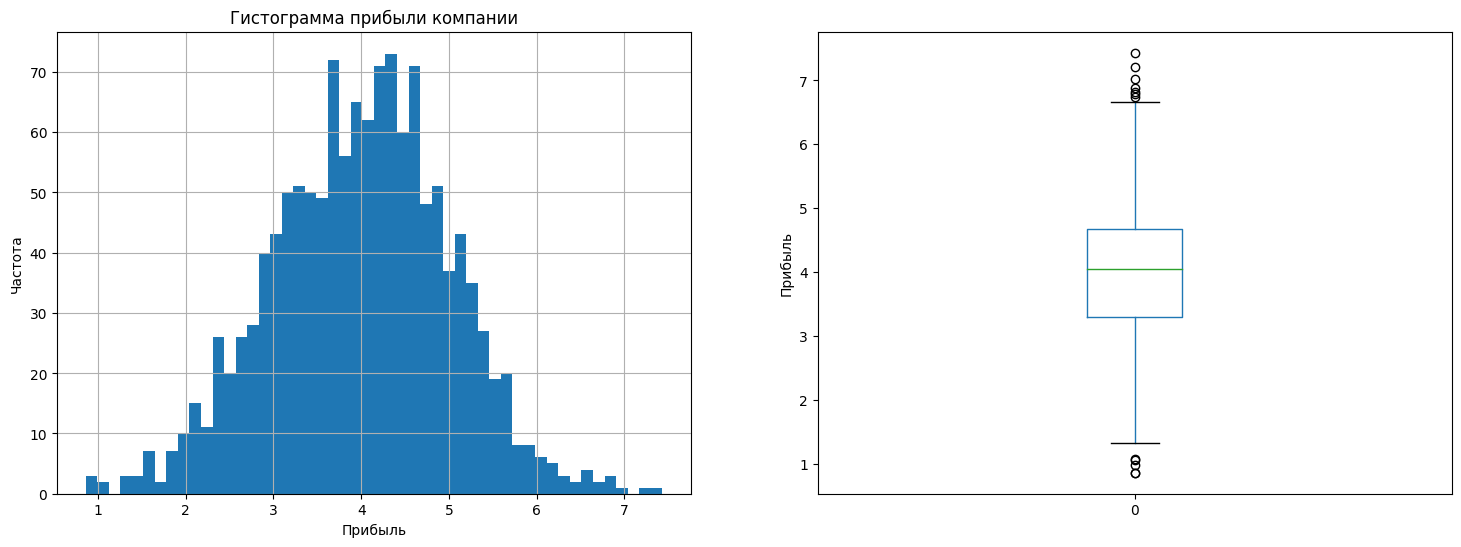

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

In [30]:
# Строим гистограмму прибыли компании и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
money['прибыль'].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма прибыли компании')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
money['прибыль'].plot.box(use_index=False)
plt.ylabel('Прибыль')
plt.show()
money['прибыль'].describe()

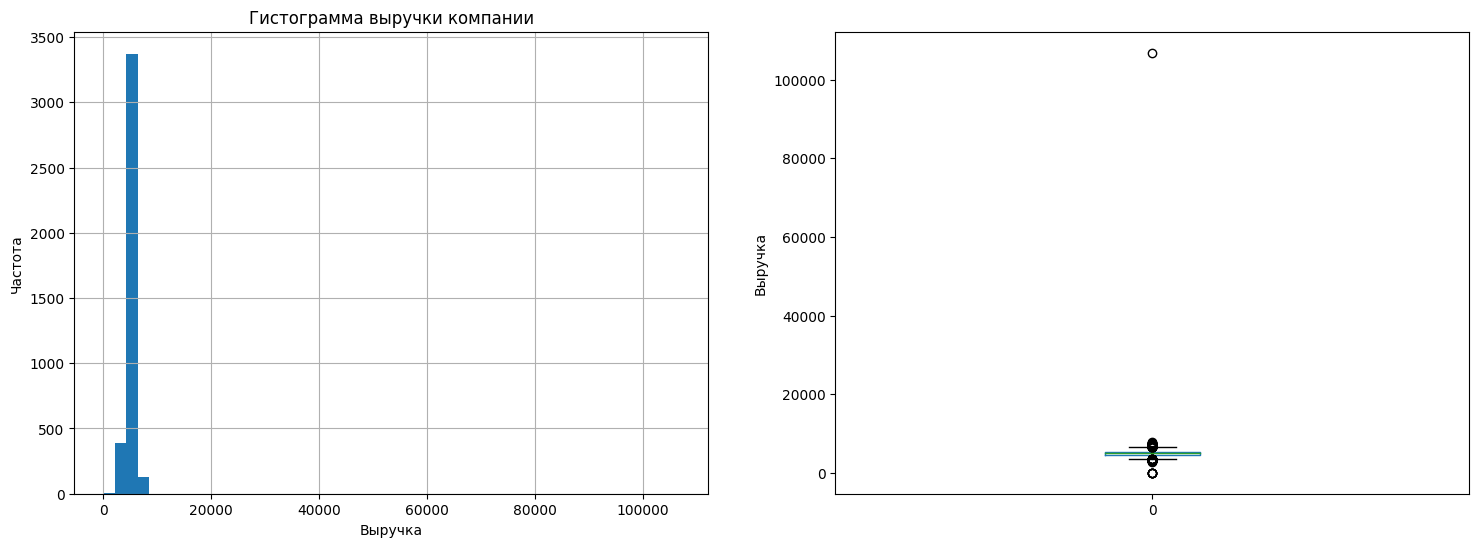

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

In [31]:
# Строим гистограмму выручки компании и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
market_money['выручка'].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма выручки компании')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
market_money['выручка'].plot.box(use_index=False)
plt.ylabel('Выручка')
plt.show()
market_money['выручка'].describe()

In [32]:
# Видим что есть аномально большое значение выручки, а также клиенты с нулевой выручкой
market_money.loc[
    (market_money['выручка'] >= 100000) 
    | (market_money['выручка'] == 0)
]

,id,период,выручка
0,215348,предпредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,предпредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,предпредыдущий_месяц,0.0
98,215380,текущий_месяц,106862.2


In [33]:
# Удаляем аномально большие и нулевые данные о выручке
market_money = (
    market_money
    .loc[
        (market_money['выручка'] != 106862.2) 
        & (market_money['выручка'] != 0)
    ]
)

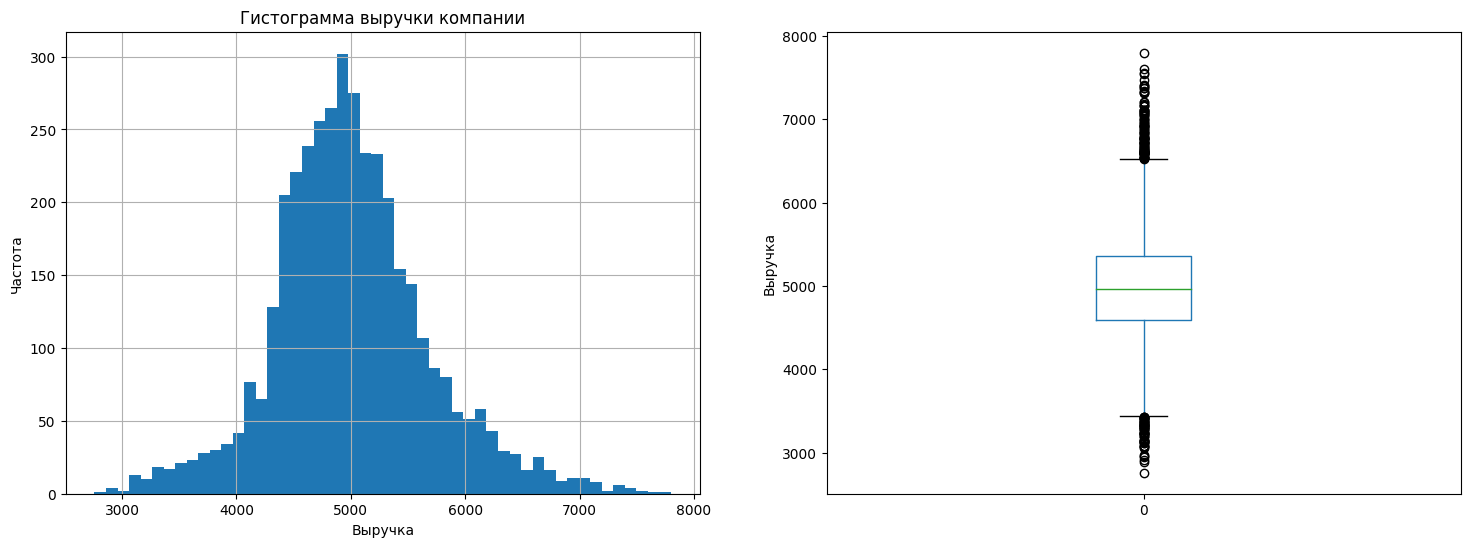

count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

In [34]:
# Строим гистограмму выручки компании и boxplot диаграмму, также смотрим описание данных без учета 
# нулевых и аномально большого значения выручки
plt.subplot(1, 2, 1)
market_money['выручка'].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма выручки компании')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
market_money['выручка'].plot.box(use_index=False)
plt.ylabel('Выручка')
plt.show()
market_money['выручка'].describe()

In [35]:
# Считаем процент данных о выручке за предпредыдущий месяц
perc_prevprev_one = round(
    market_money.loc[market_money['период'] == 'предпредыдущий_месяц']['выручка']
    .count() / market_money['выручка'].count() * 100, 2
)
# Считаем процент данных о выручке за предыдущий месяц
perc_prev_one = round(
    market_money.loc[market_money['период'] == 'предыдущий_месяц']['выручка']
    .count() / market_money['выручка'].count() * 100, 2
)
# Считаем процент данных о выручке за текущий месяц
perc_curr_one = round(
    market_money.loc[market_money['период'] == 'текущий_месяц']['выручка']
    .count() / market_money['выручка'].count() * 100, 2
)

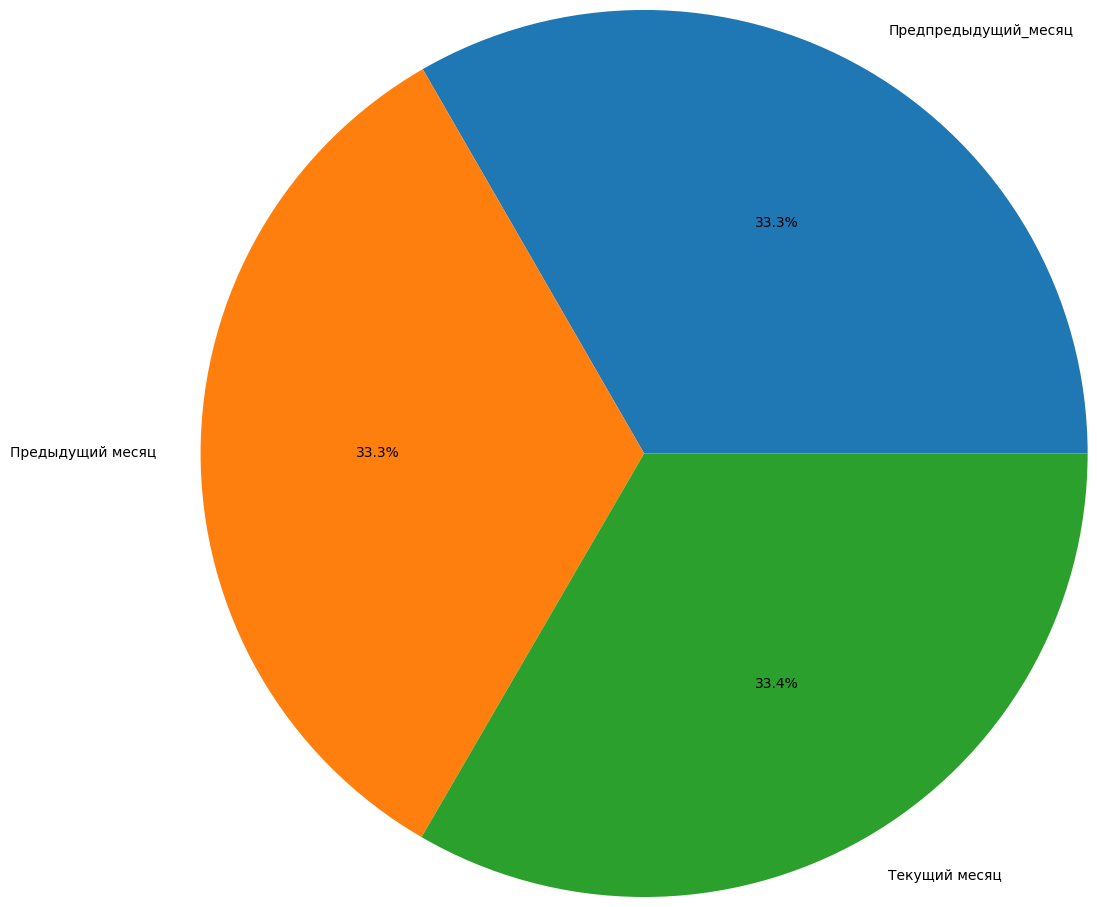

In [36]:
# Строим пай-диаграму данных о выручке за текущий и за предыдуший месяцы
plt.pie([perc_prevprev_one, perc_prev_one, perc_curr_one], labels = ['Предпредыдущий_месяц', 'Предыдущий месяц', 'Текущий месяц'], radius=3, autopct='%1.1f%%')
plt.show()

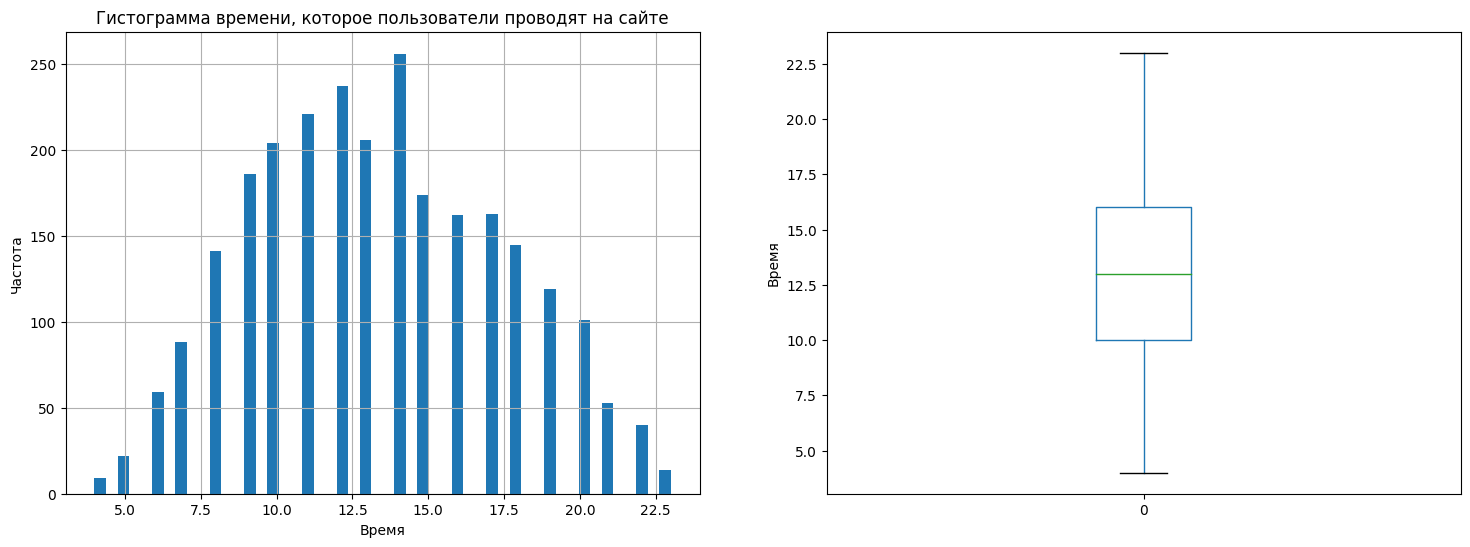

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

In [37]:
# Строим гистограмму времени, которое пользователи проводят на сайте и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
market_time['минут'].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма времени, которое пользователи проводят на сайте')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
market_time['минут'].plot.box(use_index=False)
plt.ylabel('Время')
plt.show()
market_time['минут'].describe()

In [38]:
# Считаем процент данных о времени, которое пользователи проводят на сайте, за предыдущий месяц
perc_prev_two = round(
    market_time.loc[market_time['период'] == 'предыдущий_месяц']['период']
    .count() / market_time['период'].count() * 100, 2
)
# Считаем процент данных о времени, которое пользователи проводят на сайте, за текущий месяц
perc_curr_two = round(
    market_time.loc[market_time['период'] == 'текущий_месяц']['период']
    .count() / market_time['период'].count() * 100, 2
)

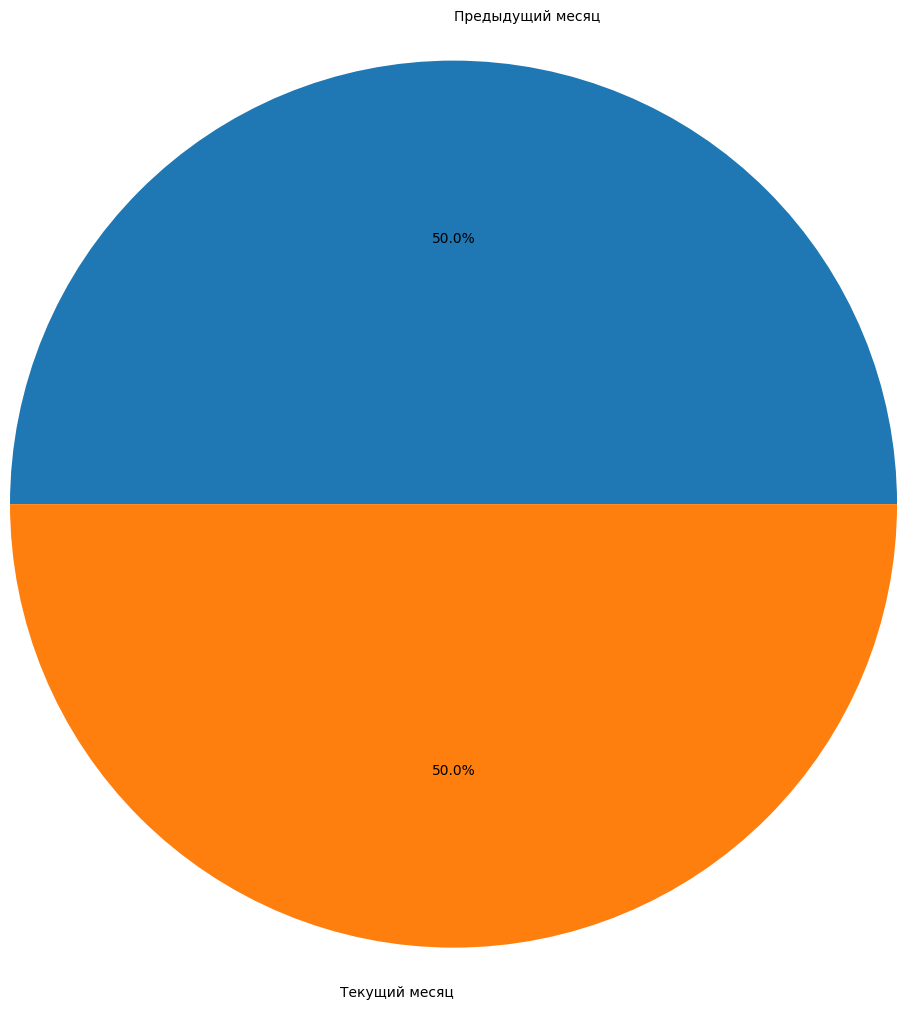

In [39]:
# Строим пай-диаграму данных о времени, которое пользователи проводят на сайте, за текущий и за предыдуший месяцы
plt.pie([perc_prev_two, perc_curr_two], labels = ['Предыдущий месяц', 'Текущий месяц'], radius=3, autopct='%1.1f%%')
plt.show()

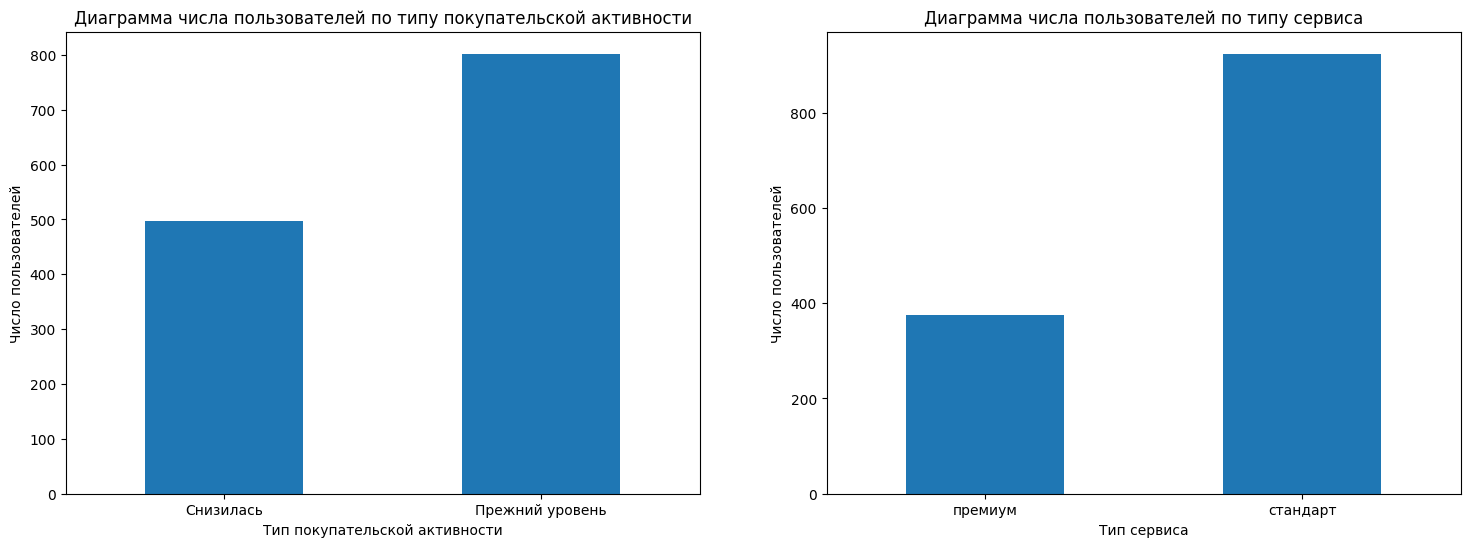

In [40]:
# Строим диаграмму числа пользователей по типу покупательской активности
plt.subplot(1, 2, 1)
(
    market_file.groupby('покупательская_активность')['покупательская_активность']
    .count().sort_values().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title('Диаграмма числа пользователей по типу покупательской активности')
plt.xlabel('Тип покупательской активности')
plt.ylabel('Число пользователей')
plt.xticks(rotation=0)
# Строим диаграмму числа пользователей по типу сервиса
plt.subplot(1, 2, 2)
(
    market_file.groupby('тип_сервиса')['тип_сервиса']
    .count().sort_values().plot(kind='bar', legend=False)
)
plt.title('Диаграмма числа пользователей по типу сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Число пользователей')
plt.xticks(rotation=0)
plt.show()

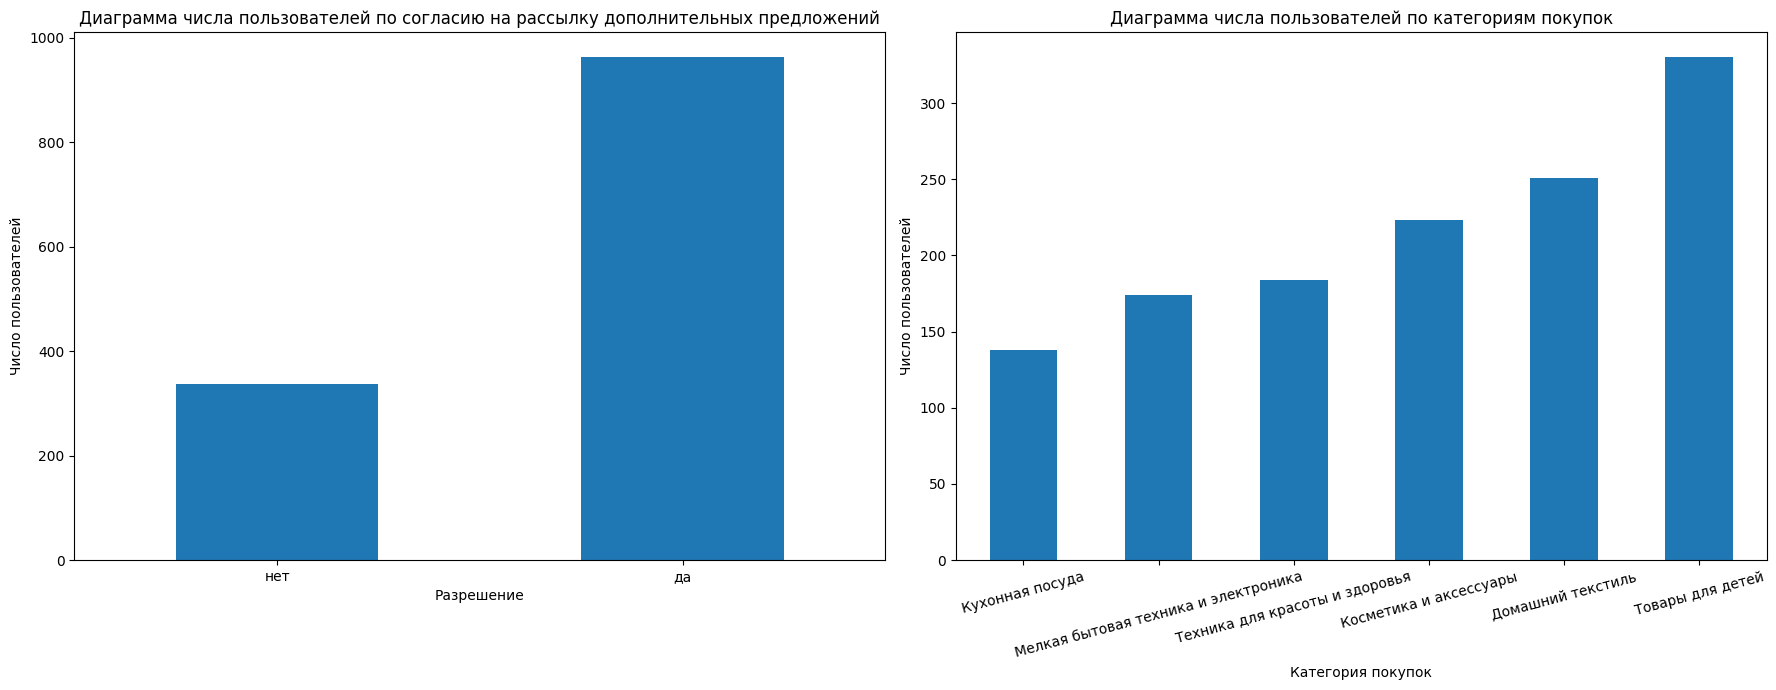

In [41]:
# Строим диаграмму числа пользователей по согласию на рассылку дополнительных предложений
plt.subplot(1, 2, 1)
(
    market_file.groupby('разрешить_сообщать')['разрешить_сообщать']
    .count().sort_values().plot(kind='bar', legend=False, figsize=(18, 7))
)
plt.title('Диаграмма числа пользователей по согласию на рассылку дополнительных предложений')
plt.xlabel('Разрешение')
plt.ylabel('Число пользователей')
plt.xticks(rotation=0)
# Строим диаграмму числа пользователей по категориям покупок
plt.subplot(1, 2, 2)
(
    market_file.groupby('популярная_категория')['популярная_категория']
    .count().sort_values().plot(kind='bar', legend=False)
)
plt.title('Диаграмма числа пользователей по категориям покупок')
plt.xlabel('Категория покупок')
plt.ylabel('Число пользователей')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

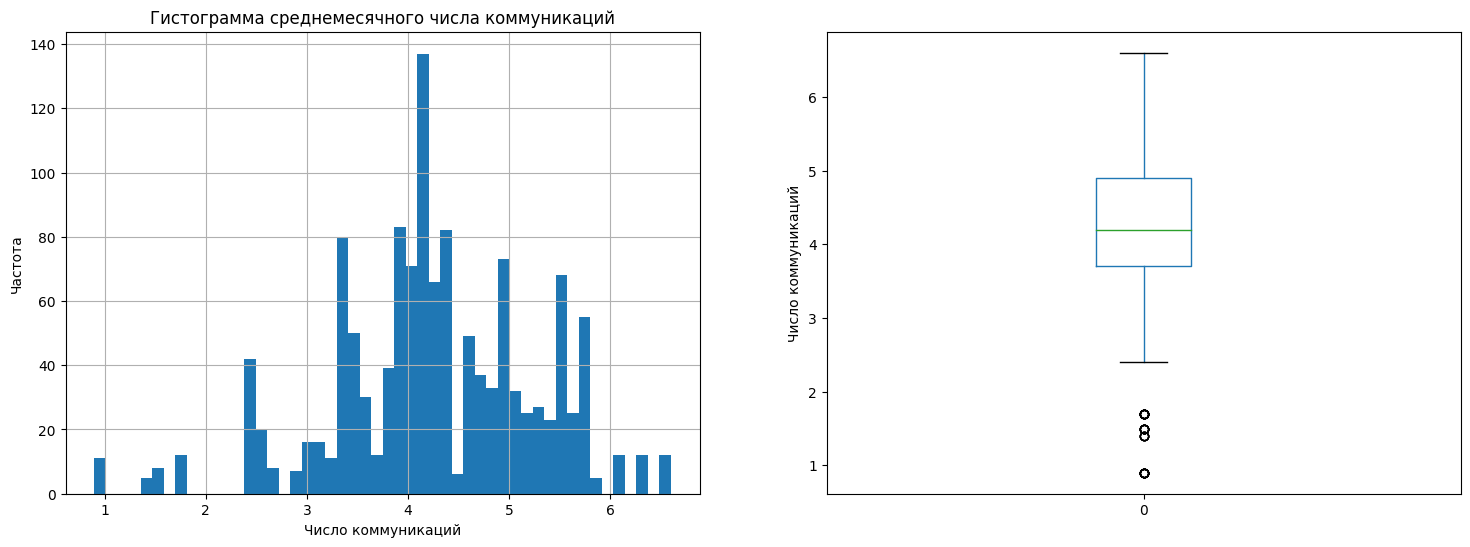

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

In [42]:
# Строим гистограмму среднемесячного числа коммуникаций с клиентом за 6 месяцев и boxplot диаграмму,
# также смотрим описание данных
plt.subplot(1, 2, 1)
market_file['маркет_актив_6_мес'].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма среднемесячного числа коммуникаций')
plt.xlabel('Число коммуникаций')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
market_file['маркет_актив_6_мес'].plot.box(use_index=False)
plt.ylabel('Число коммуникаций')
plt.show()
market_file['маркет_актив_6_мес'].describe()

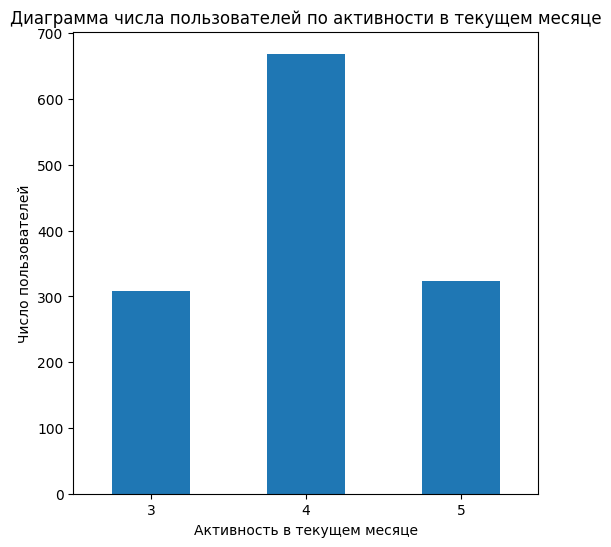

In [43]:
# Строим диаграмму числа пользователей по активности в текущем месяце
(
    market_file.groupby('маркет_актив_тек_мес')['маркет_актив_тек_мес']
    .count().plot(kind='bar', legend=False, figsize=(6, 6))
)
plt.title('Диаграмма числа пользователей по активности в текущем месяце')
plt.xlabel('Активность в текущем месяце')
plt.ylabel('Число пользователей')
plt.xticks(rotation=0)
plt.show()

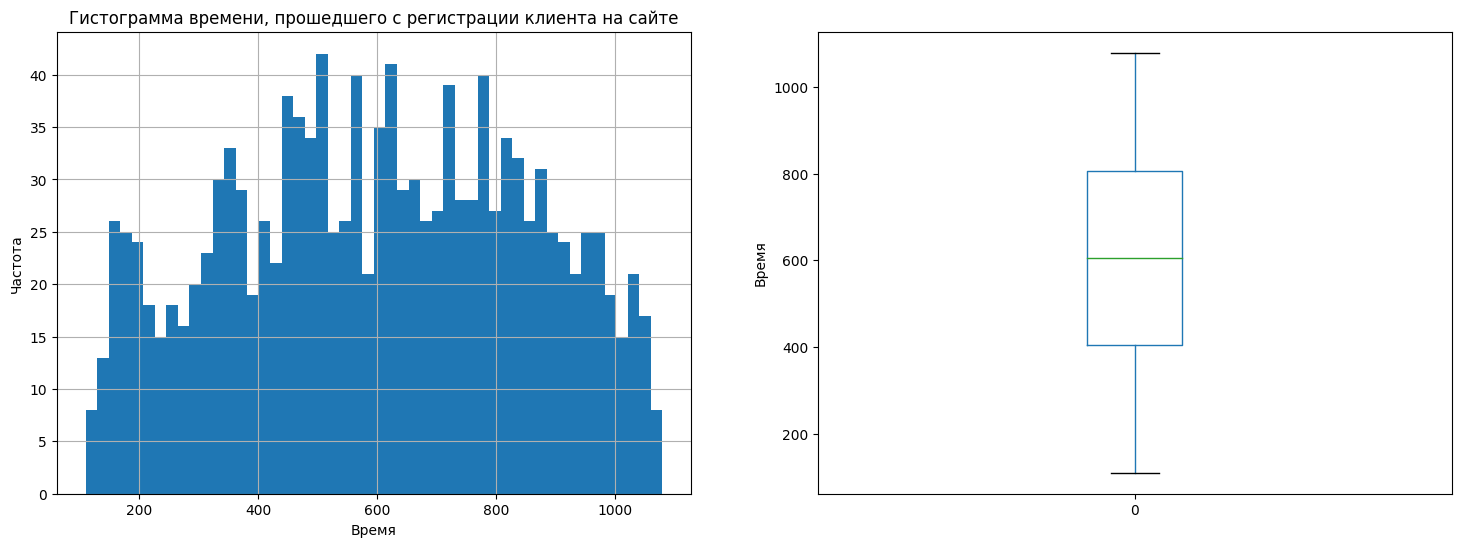

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

In [44]:
# Строим гистограмму времени, прошедшего с регистрации клиента на сайте boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
market_file['длительность'].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма времени, прошедшего с регистрации клиента на сайте')
plt.xlabel('Время')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
market_file['длительность'].plot.box(use_index=False)
plt.ylabel('Время')
plt.show()
market_file['длительность'].describe()

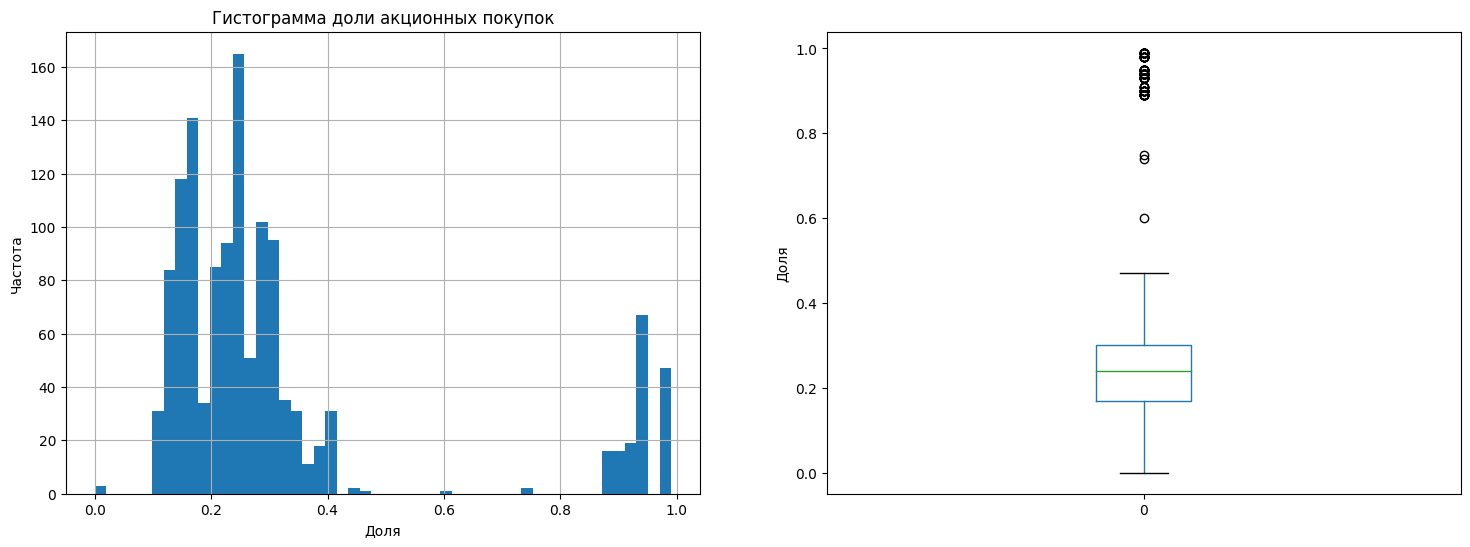

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

In [45]:
# Строим гистограмму доли акционных покупок и boxplot диаграмму, также смотрим описание данных
plt.subplot(1, 2, 1)
market_file['акционные_покупки'].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма доли акционных покупок')
plt.xlabel('Доля')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
market_file['акционные_покупки'].plot.box(use_index=False)
plt.ylabel('Доля')
plt.show()
market_file['акционные_покупки'].describe()

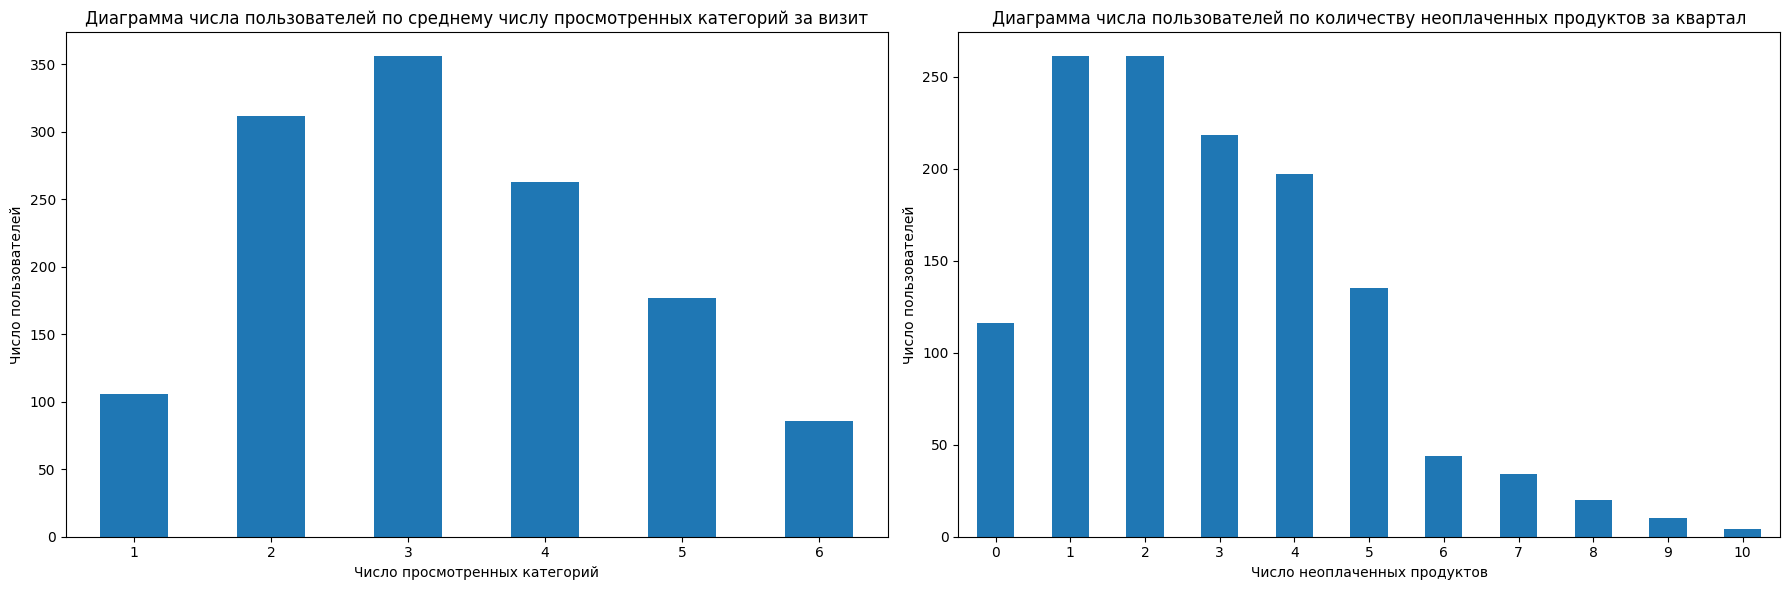

In [46]:
# Строим диаграмму числа пользователей по среднему числу просмотренных категорий за визит
plt.subplot(1, 2, 1)
(
    market_file.groupby('средний_просмотр_категорий_за_визит')['средний_просмотр_категорий_за_визит']
    .count().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title('Диаграмма числа пользователей по среднему числу просмотренных категорий за визит')
plt.xlabel('Число просмотренных категорий')
plt.ylabel('Число пользователей')
plt.xticks(rotation=0)
# Строим диаграмму числа пользователей по количеству неоплаченных продуктов за квартал
plt.subplot(1, 2, 2)
(
    market_file.groupby('неоплаченные_продукты_штук_квартал')['неоплаченные_продукты_штук_квартал']
    .count().plot(kind='bar', legend=False)
)
plt.title('Диаграмма числа пользователей по количеству неоплаченных продуктов за квартал')
plt.xlabel('Число неоплаченных продуктов')
plt.ylabel('Число пользователей')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

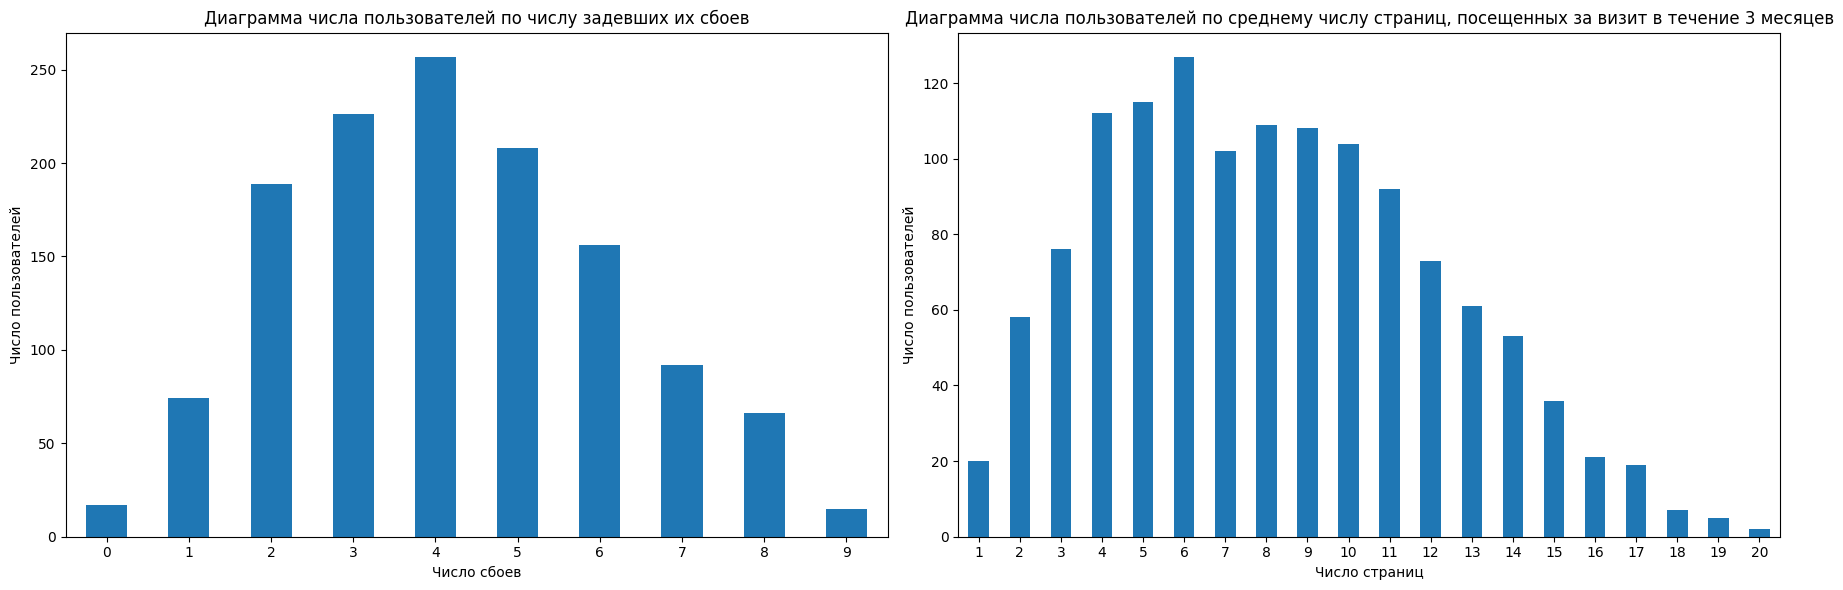

In [47]:
# Строим диаграмму числа пользователей по числу задевших их сбоев
plt.subplot(1, 2, 1)
(
    market_file.groupby('ошибка_сервиса')['ошибка_сервиса']
    .count().plot(kind='bar', legend=False, figsize=(18, 6))
)
plt.title('Диаграмма числа пользователей по числу задевших их сбоев')
plt.xlabel('Число сбоев')
plt.ylabel('Число пользователей')
plt.xticks(rotation=0)
# Строим диаграмму числа пользователей по среднему числу страниц, посещенных за визит в течение 3 месяцев
plt.subplot(1, 2, 2)
(
    market_file.groupby('страниц_за_визит')['страниц_за_визит']
    .count().plot(kind='bar', legend=False)
)
plt.title('Диаграмма числа пользователей по среднему числу страниц, посещенных за визит в течение 3 месяцев')
plt.xlabel('Число страниц')
plt.ylabel('Число пользователей')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Промежуточный вывод:** 
* Прибыль компании распределена нормально, есть выбросы значений с обеих сторон.   
* Выручка компании от клиентов распределена нормально, есть аномально большое значение выручки и клиенты с нулевой выручкой.
* Соотношение данных о выручке за предыдущий и текущий месяцы - 2 к 1.
* Время, проведенное клиентами на сайте распределено нормально.
* Соотношение данных о времени, проведенном клиентами на сайте за предыдущий и текущий месяцы - 1 к 1.
* У примерно 800 клиентов активность не изменилась, у 500 клиенктов активность снизилась.
* Соотношение клиентов использующих стандартный и премиум сервис примерно 2 к 1.
* Большая часть клиентов разрешает сообщать о дополнительных предложениях.
* Большая часть пользователей интересуется товарами для детей, меньшая кухонной посудой.
* Среднее число коммуникаций с клиентами распределено нормально, есть выбросы низких средних чисел коммуникации.
* В текущий месяц числа коммуникаций с клиентами 3, 4 и 5 в соотношении 1 к 2 к 1.
* Время, прошедшее с момента регистрации распределено равномерно по числу пользователей.
* Доля акционных покупок распределена нормально, есть выбросы со стороны высокой доли числа акционных покупок.
* Среднее число просмотренных за визит категорий распределено нормально, с максимумом на 3 категориях.
* Число неоплаченных пользователями за квартал продуктов распределено со смещением к нулю, с максимумом на 1 и 2.
* Число ошибок сервиса, с которыми сталкиваются пользователи распределено нормально/
* Число страниц, которые посещает пользователь за визит распределено нормально, с абсолютным максимумом на 6 страницах. Можно наблюдать наличие второго максимума на 8 страницах.

<a id='merge'></a>
## [Объединение данных](#start)

In [48]:
# Добавляем данные о выручке за каждый период в отдельный столбец
market_file = market_file.merge(market_money.loc[market_money['период'] == 'текущий_месяц'][['id', 'выручка']], on='id')
market_file = market_file.merge(market_money.loc[market_money['период'] == 'предыдущий_месяц'][['id', 'выручка']], on='id')
market_file = market_file.merge(market_money.loc[market_money['период'] == 'предпредыдущий_месяц'][['id', 'выручка']], on='id')
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_x,выручка_y,выручка
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0


In [49]:
# Переименовываем получившиеся столбцы
columns = {
    'выручка_x':'выручка_за_тек_мес',
    'выручка_y':'выручка_за_пред_мес',
    'выручка':'выручка_за_предпред_мес'
}
market_file = market_file.rename(columns=columns)

In [50]:
# Добавляем данные о времени, проведенном на сайте пользователями за каждый период
market_file = market_file.merge(market_time.loc[market_time['период'] == 'текущий_месяц'][['id', 'минут']], on='id')
market_file = market_file.merge(market_time.loc[market_time['период'] == 'предыдущий_месяц'][['id', 'минут']], on='id')
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_тек_мес,выручка_за_пред_мес,выручка_за_предпред_мес,минут_x,минут_y
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10,12
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13,8
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13,11
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11,8
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10,10


In [51]:
# Переименовываем получившиеся столбцы
columns = {
    'минут_x':'минут_за_тек_мес',
    'минут_y':'минут_за_пред_мес'
}
market_file = market_file.rename(columns=columns)

In [52]:
# Находим пользователей, которые не совершали покупки в предыдущем и предпредыдущем месяцах
market_file.loc[(market_file['выручка_за_пред_мес'] == 0) | (market_file['выручка_за_предпред_мес'] == 0)]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_тек_мес,выручка_за_пред_мес,выручка_за_предпред_мес,минут_за_тек_мес,минут_за_пред_мес


In [53]:
# Устанавливаем столбец 'id' как индекс, чтобы он не учитывался при расчете коэффициентов корреляции и
# при моделировании
market_file = market_file.set_index('id')

**Таких пользователей уже нет в датасете, т.к. они были удалены вместе с потзователем с аномальным значением выручки на этапе исследовательского анализа данных.**

In [54]:
# Проверяем финальную инофрмацию о датасете
market_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит       

**Промежуточный вывод:** 
* Данные объединены в соответствии с заданием
* Из итоговой таблицы удалены пользователи, не совершавшие покупок в течение предыдущего и предпредыдущего месяцев

<a id='corr'></a>
## [Корреляционный анализ](#start)

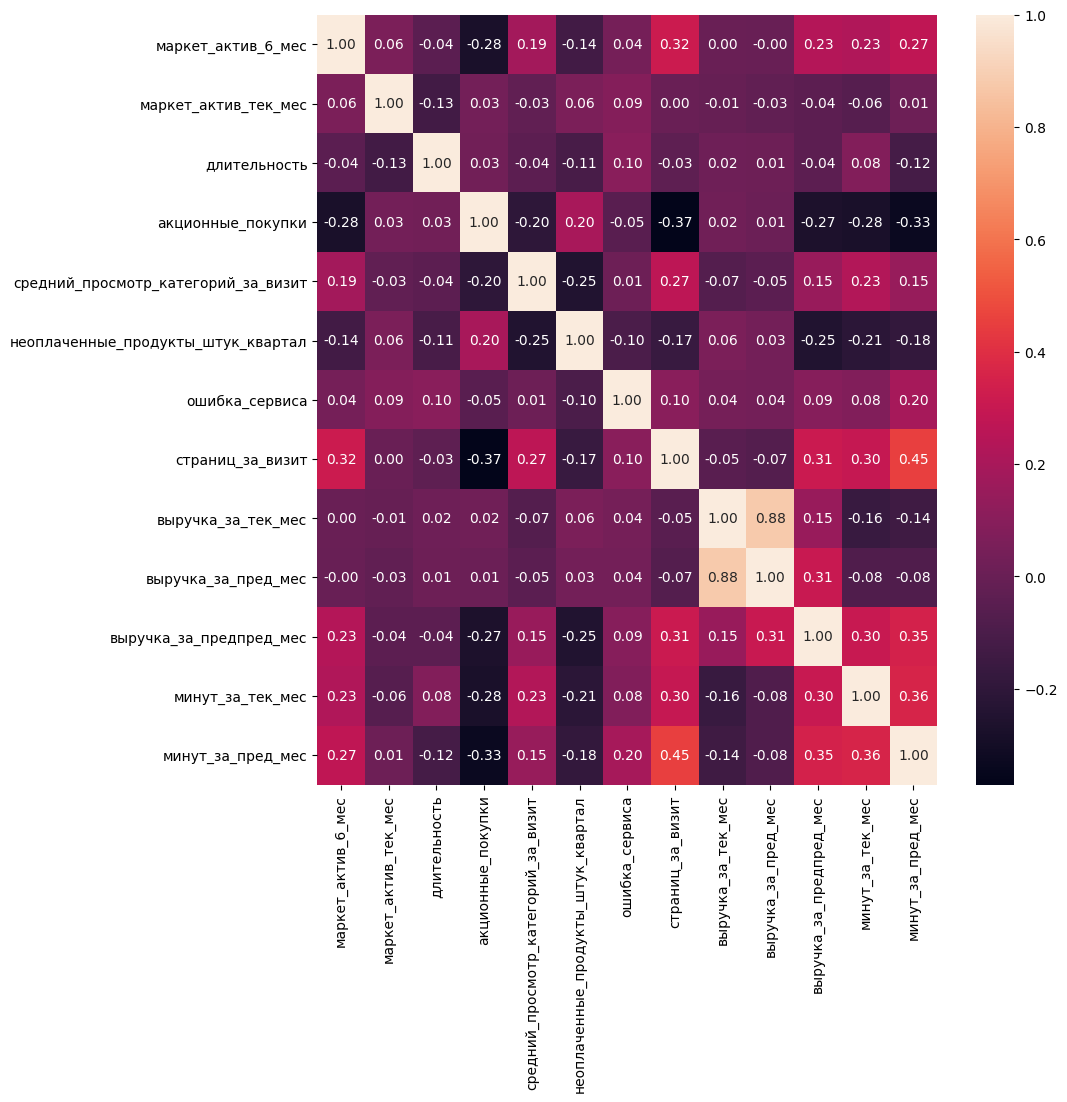

In [55]:
# Строим тепловую карту коэффициентов корреляции Пирсона
fig, ax = plt.subplots(figsize=(10, 10))
# Удалим из расчета коэффициентов id пользователей
sns.heatmap(market_file.corr(method='spearman'), annot=True, fmt='.2f', ax=ax)
plt.show()

**В матрице нет признаков с коэффициентом корреляции от 0.9 до 0.95 по модулю.  
Можно сделать вывод об отсутствии мультиколлинеарности.**

<a id='models'></a>
## [Разработка моделей](#start)

In [56]:
# Подготавливаем данные для моделирования
# Установим RANDOM_STATE = 42
RANDOM_STATE = 42
# Разделим датасет на датасеты с входными и целевым признаком
X_train, X_test, y_train, y_test = train_test_split(
    market_file.drop(['покупательская_активность'], axis=1),
    market_file['покупательская_активность'],
    random_state = RANDOM_STATE,
    stratify = market_file['покупательская_активность']
)
# Создаем список категориальных признаков
cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
cat_col_for_ohe = [cat_col_names[2]]
cat_col_for_ord = [cat_col_names[0], cat_col_names[1],]
# Создаем список количественных признаков
num_col_names = X_train.select_dtypes(include='number').columns.tolist()
# Подготовим список категорий для Ordinal-кодирования
categories = [X_train[cat_col_for_ord[0]].unique(), X_train[cat_col_for_ord[1]].unique()]

In [57]:
# Выводим какие категории будут кодироваться OneHotEncoder
print('Для ohe-кодирования выбрана колонка -', cat_col_for_ohe)

Для ohe-кодирования выбрана колонка - ['популярная_категория']


In [58]:
print('Для ord-кодирования выбраны колонки -', cat_col_for_ord)

Для ord-кодирования выбраны колонки - ['тип_сервиса', 'разрешить_сообщать']


In [59]:
# Создаем pipeline для ohe-кодирования
ohe_pipe = Pipeline(
    [
        ('ohe', 
         OneHotEncoder(
             drop='first', 
             handle_unknown='ignore', 
             sparse_output=False
         )
        )
    ]
)

In [60]:
# Создаем pipeline для ord-кодирования
ord_pipe = Pipeline(
    [
        ('ord', 
         OrdinalEncoder(
             categories=categories, 
             handle_unknown='use_encoded_value', 
             unknown_value=np.nan
         )
        )
    ]
)

In [61]:
# Объединяем пайплайны для кодирования и масштабирования
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col_for_ohe),
        ('ord', ord_pipe, cat_col_for_ord),
        ('num', StandardScaler(), num_col_names)
    ], 
    remainder='passthrough'
)
# Создаем лист со словарями, в которых находятся модели и наборы гиперпараметров
param_grid = [
    {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE
        )],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [
            StandardScaler(), MinMaxScaler(), 
            RobustScaler(), 'passthrough'
        ]  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [
            StandardScaler(), MinMaxScaler(), 
            RobustScaler(), 'passthrough'
        ]   
    },
    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(2, 5),
        'preprocessor__num': [
            StandardScaler(), MinMaxScaler(), 
            RobustScaler(), 'passthrough'
        ]  
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 0.5, 1, 1.5, 2, 2.5, 3],
        'models__gamma': [0.1, 0.5, 1, 1.5, 2, 2.5, 3],
        'preprocessor__num': [
            StandardScaler(), MinMaxScaler(), 
            RobustScaler(), 'passthrough'
        ]   
    }
]

In [62]:
# Объединяем пайплайны предобработки и моделирования в фильнальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(
            random_state=RANDOM_STATE
        )
        )
    ]
)

**В качестве метрики используем roc_auc_score. Эта метрика позволяет оценить качество моделей учитывая все пороговые значения, а также эта метрика не чувствительна к дисбалансу значений целевого класса, который наблюдается у используемого в работе датасета.**

In [63]:
# Создаем объект класса GridSearchCV для поиска оптимальной модели и гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
)
# Обучаем grid на тренировочных данных
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(categories=[array(['стандарт', 'премиум'], dtype=object),
                                                                                                                     arr...
                                                        solver='liblinear')],
                          'models__C': range(2, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'models__C': [0.1, 0.5, 1, 1.5, 2, 2.5, 3],
                          'models__gamma': [0.1, 0.5, 1, 1.5, 2, 2.5, 3],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [64]:
print(
    'Лучшая модель и её параметры:\n\n', 
    grid.best_estimator_
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[array(['стандарт', 'премиум'], dtype=object),
                                                                                         

In [65]:
print(
    'Метрика лучшей модели на кросс-валидационной выборке:', 
    round(grid.best_score_, 3)
)

Метрика лучшей модели на кросс-валидационной выборке: 0.913


**Проведем моделирование с помощью лучшей модели на тестовой выборке.**

In [66]:
# Обучим модель с лучшими гиперпараметрами
best_model = grid.best_estimator_.fit(X_train, y_train)
# Проведем предсказание на тестовой выборке
preds = best_model.predict_proba(X_test)
# Расчитаем roc_auc_score для тестовой выборки
print(
    'Метрика лучшей модели на тренировочной выборке:', 
    round(roc_auc_score(y_test, preds[:,1]), 3)
)

Метрика лучшей модели на тренировочной выборке: 0.913


<a id='importance'></a>
## [Анализ важности признаков](#start)

In [67]:
# С помощью shap создаем Explainer для модели
explainer = shap.Explainer(
    best_model[1].predict_proba, 
    best_model[0].transform(X_test), 
    feature_names=best_model[0].get_feature_names_out()
)

In [68]:
# Расчитываем shap_values 
shap_values = explainer(best_model[0].transform(X_test))

PermutationExplainer explainer: 325it [06:09,  1.16s/it]                                                               


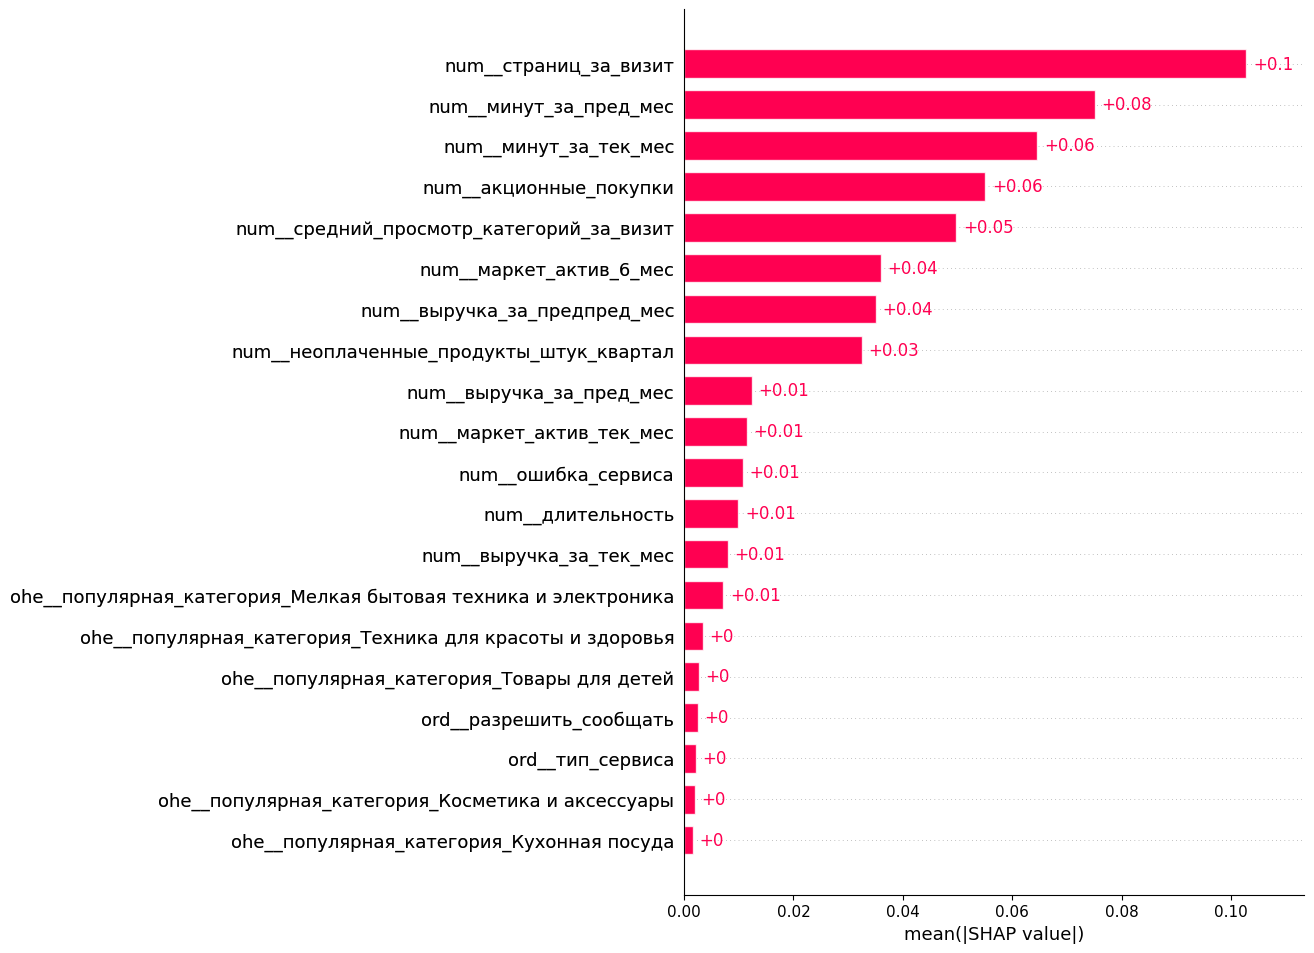

In [69]:
# Строим диаграмму важности признаков
shap.plots.bar(shap_values[:, :, 1], max_display=20)

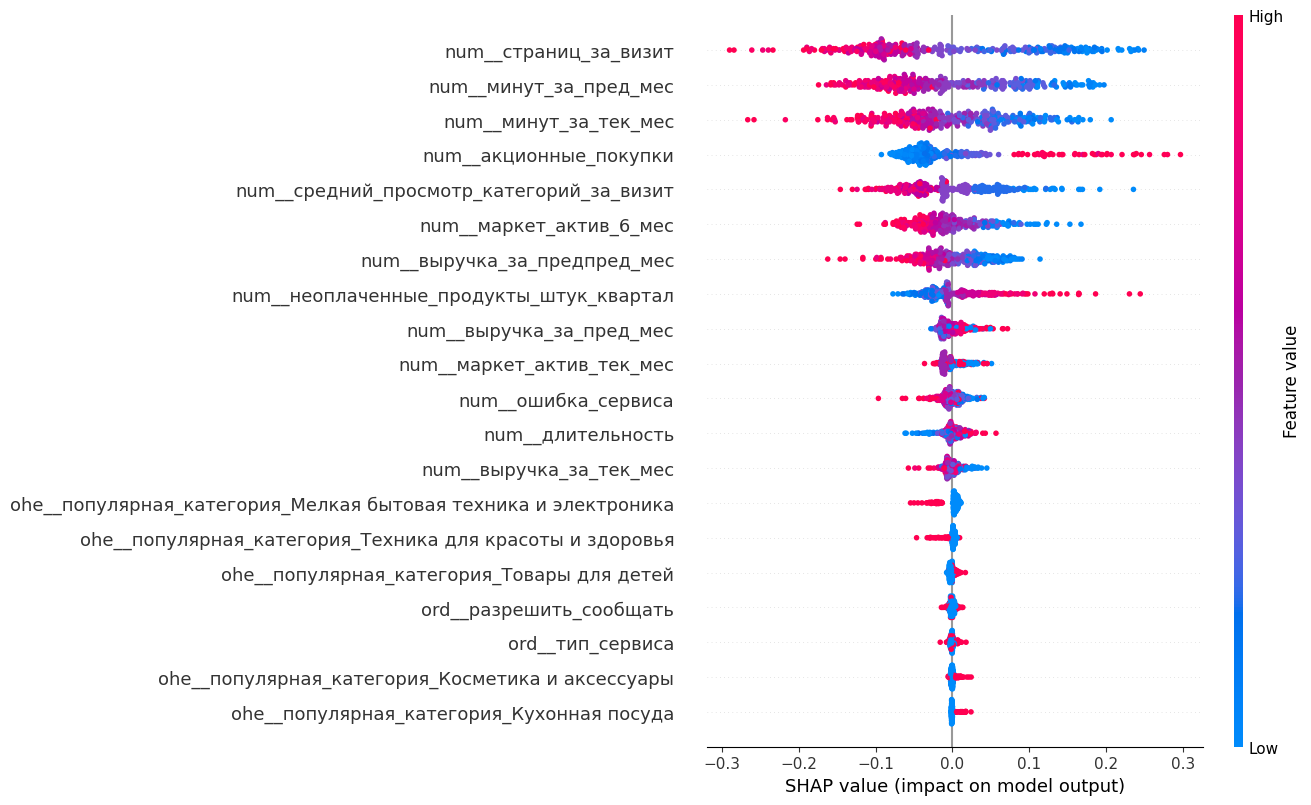

In [70]:
# Строим диаграмму важности признаков
shap.plots.beeswarm(shap_values[:, :, 1], max_display=20)

**Промежуточный вывод:** 
* Самыми важными признаками являются количество страниц, которые посещает пользователь за визит, доля акционных покупок, а также время, которое пользователи проводят на сайте в текущий и предыдущие месяцы.
* На активность пользователей мало влияют тип сервиса, разрешение на рассылку дополнительной информации и то, как давно они зарегистрировались на сайте.
* Исходя из beeswarm диаграммы можно сказать, что чем меньше страниц пользователь посещает за визит, тем выше целевой показатель.
* Тоже самае можно сказать о времени, которое пользователи проводят на сайте в текущий и предыдущий месяцы.
* Исходя из beeswarm диаграммы можно сказать, что чем больше акций и неоплаченных товаров за квартал , тем выше целевой показатель.

<a id='segment'></a>
## [Анализ пользователей сервиса](#start)

**Так как у нас есть данные тестового моделирования сформируем датасет с предсказаниями активности клиентов и их прибыльностью ждя компании на основе датасета X_test. Далее разделим этот датасет на сегмент с пользователями с высокой прибыльносью, у которых предсказанная активность остается на прежнем уровне и на сегмент с пользователями, у которых активность должна снизиться.**

In [71]:
# Предсказывает активность клиентов
y_preds = best_model.predict(X_test)
# Добавляем к датасету X_test полученные предсказания 
X_test['предсказанная активность'] = y_preds

In [72]:
# Добавляем в X_test информацию о прибыльности клиентов
X_test = X_test.merge(money, on='id')
# Проверяем полученый датасет
X_test.info()
X_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   324 non-null    int64  
 1   тип_сервиса                          324 non-null    object 
 2   разрешить_сообщать                   324 non-null    object 
 3   маркет_актив_6_мес                   324 non-null    float64
 4   маркет_актив_тек_мес                 324 non-null    int64  
 5   длительность                         324 non-null    int64  
 6   акционные_покупки                    324 non-null    float64
 7   популярная_категория                 324 non-null    object 
 8   средний_просмотр_категорий_за_визит  324 non-null    int64  
 9   неоплаченные_продукты_штук_квартал   324 non-null    int64  
 10  ошибка_сервиса                       324 non-null    int64  
 11  страниц_за_визит                

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_за_тек_мес,выручка_за_пред_мес,выручка_за_предпред_мес,минут_за_тек_мес,минут_за_пред_мес,предсказанная активность,прибыль
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3289.2,3973.0,4912.0,17,16,Прежний уровень,4.69
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,4170.7,3548.0,4656.0,9,11,Снизилась,2.75
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,6335.8,5444.0,4565.0,11,20,Прежний уровень,3.16
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6758.7,6604.0,4993.0,9,9,Снизилась,3.74
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5773.8,5090.0,4451.0,18,15,Прежний уровень,4.40


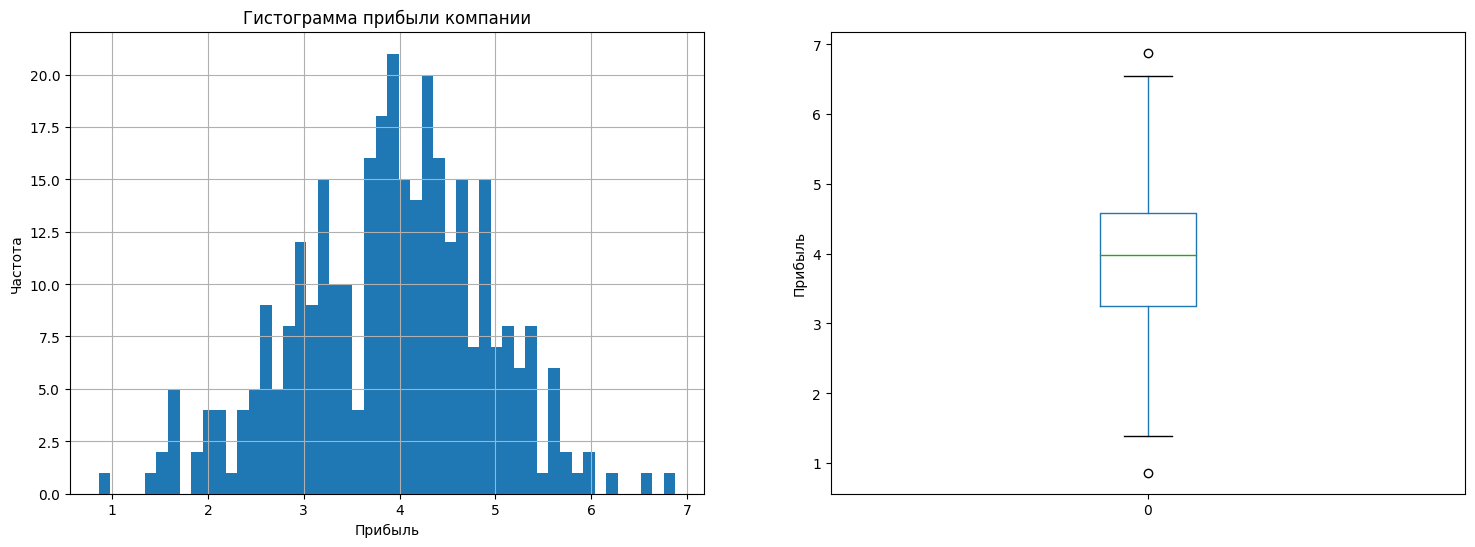

In [73]:
# Строим гистограмму прибыли компании для тестовой выборки и boxplot диаграмму
plt.subplot(1, 2, 1)
X_test['прибыль'].hist(bins=50, figsize=(18, 6))
plt.title('Гистограмма прибыли компании')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
X_test['прибыль'].plot.box(use_index=False)
plt.ylabel('Прибыль')
plt.show()

**Сегментируем клиентов по средним значениям прибыльности. Это клиенты с прибылью от 3 до 5. Сразу же разделим пользователей на два датасета (со сниженной активностью и с текущей активностью).**

In [74]:
# Создаем датасет с пользователям с прибылью от 3 до 5, у которых предсказанная активность снижается
X_test_middle_low_act = (
    X_test.loc[
        (X_test['прибыль'] >= 3) 
        & (X_test['прибыль'] <= 5) 
        & (X_test['предсказанная активность'] == 'Снизилась')]
)
# Создаем датасет с пользователям с прибылью от 3 до 5, у которых предсказанная активность остается на прежнем уровне
X_test_middle_curr_act = (
    X_test.loc[
        (X_test['прибыль'] >= 3) 
        & (X_test['прибыль'] <= 5) 
        & (X_test['предсказанная активность'] == 'Прежний уровень')]
)

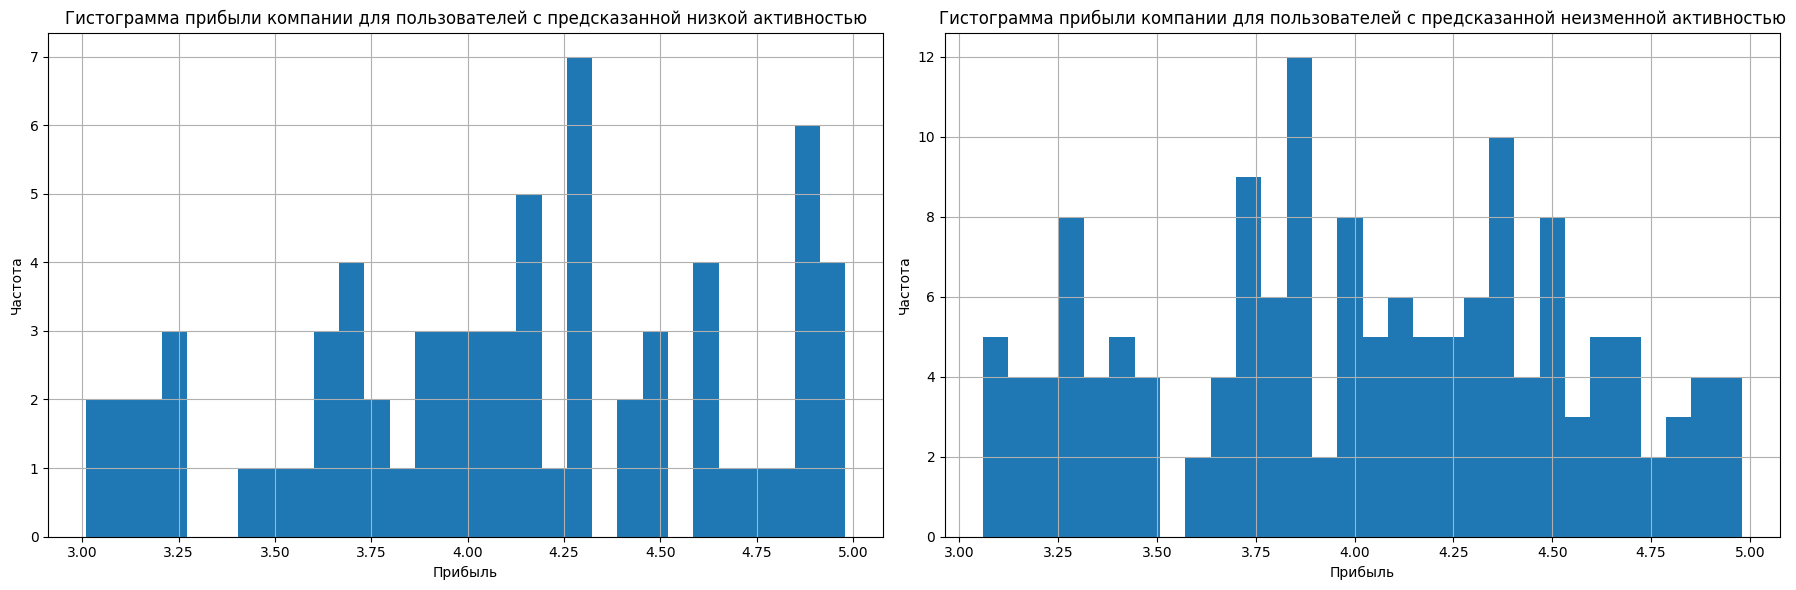

In [75]:
# Строим гистограмму прибыли компании для пользователей с предсказанной низкой активностью
plt.subplot(1, 2, 1)
X_test_middle_low_act['прибыль'].hist(bins=30, figsize=(18, 6))
plt.title('Гистограмма прибыли компании для пользователей с предсказанной низкой активностью')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
# Строим гистограмму прибыли компании для пользователей с предсказанной неизменной активностью
X_test_middle_curr_act['прибыль'].hist(bins=30, figsize=(18, 6))
plt.title('Гистограмма прибыли компании для пользователей с предсказанной неизменной активностью')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

**Можно увидеть, что клиентов с неизменной активностью в общем большена всем интервале прибылей. Среди клиентов с предсказанной низкой активностью заметно меньше клиентов с прибыль от 3 до 3.5.**

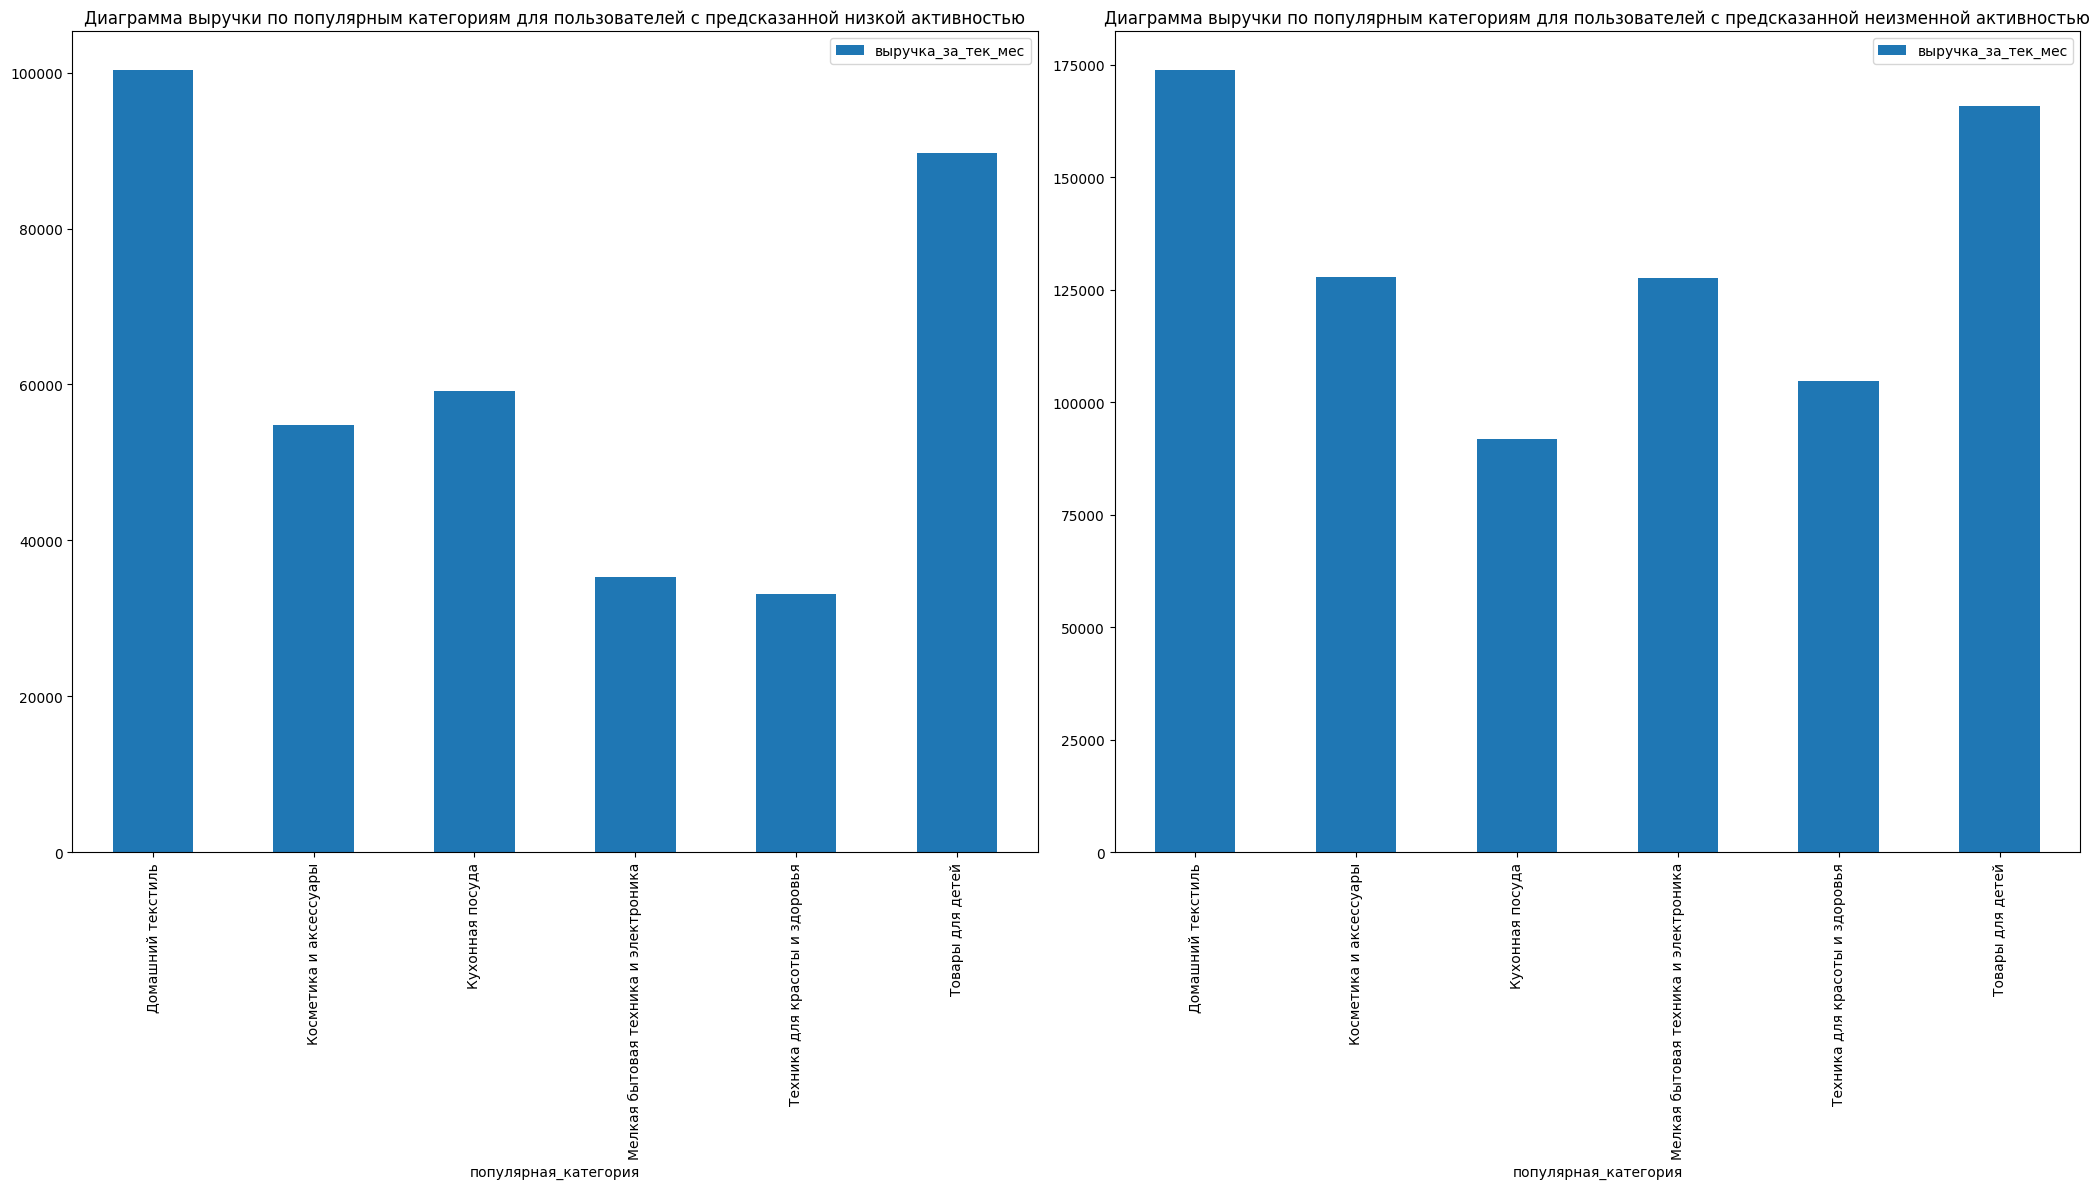

In [76]:
# Строим диаграмму выручки по популярным категориям для пользователей с предсказанной низкой активностью
# за текущий месяц
plt.subplot(1, 2, 1)
(
    X_test_middle_low_act.groupby('популярная_категория')['выручка_за_тек_мес']
    .sum().plot(kind='bar', legend=True, figsize=(21, 12))
)
plt.title('Диаграмма выручки по популярным категориям для пользователей с предсказанной низкой активностью')
# Строим диаграмму выручки по популярным категориям для пользователей с предсказанной неизменной активностью
# за текущий месяц
plt.subplot(1, 2, 2)
(
    X_test_middle_curr_act.groupby('популярная_категория')['выручка_за_тек_мес']
    .sum().plot(kind='bar', legend=True)
)
plt.title('Диаграмма выручки по популярным категориям для пользователей с предсказанной неизменной активностью')
plt.tight_layout()
plt.show()

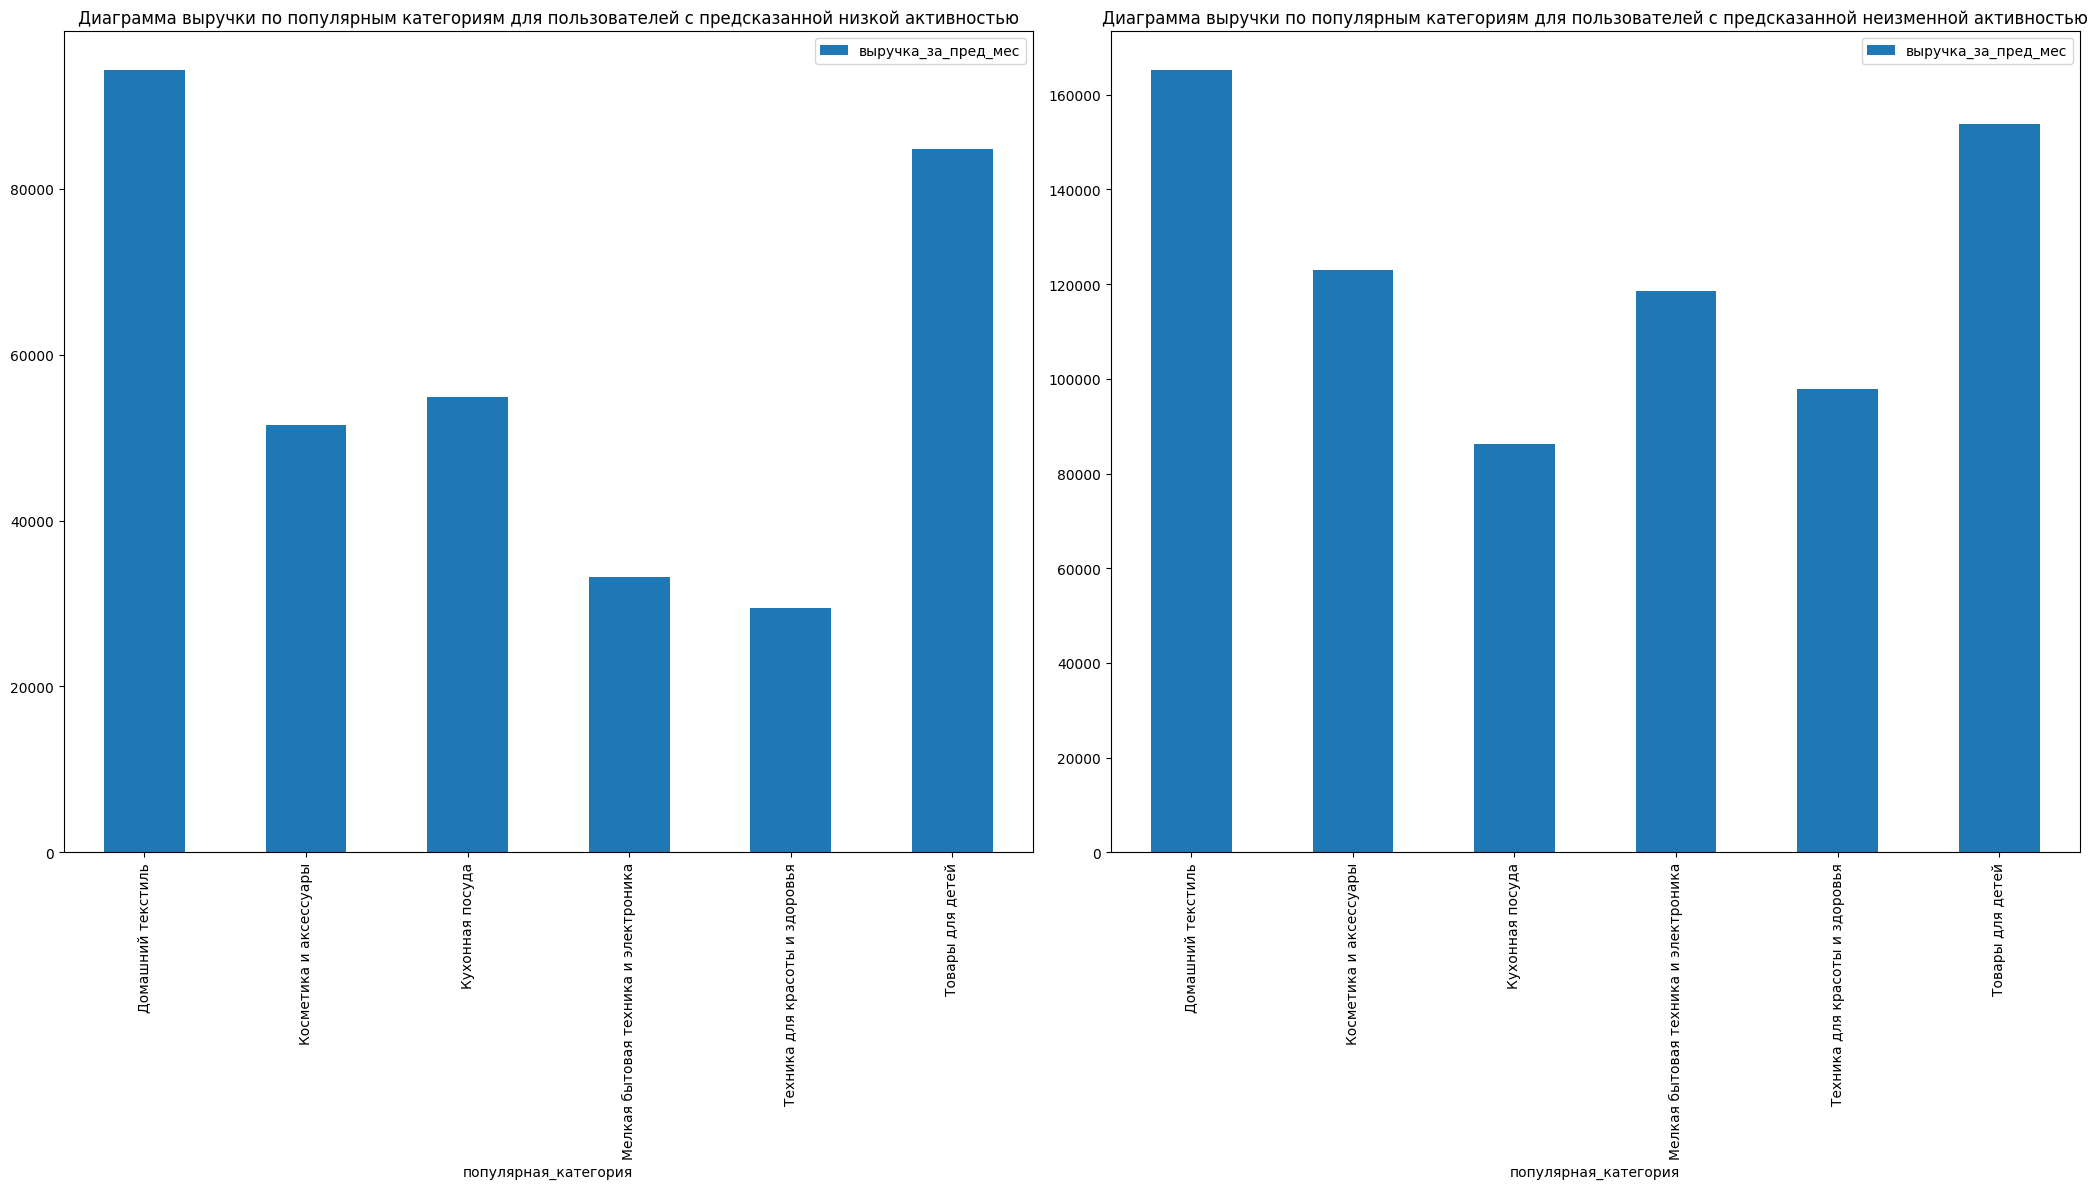

In [77]:
# Строим диаграмму выручки по популярным категориям для пользователей с предсказанной низкой активностью
# за предыдущий месяц
plt.subplot(1, 2, 1)
(
    X_test_middle_low_act.groupby('популярная_категория')['выручка_за_пред_мес']
    .sum().plot(kind='bar', legend=True, figsize=(21, 12))
)
plt.title('Диаграмма выручки по популярным категориям для пользователей с предсказанной низкой активностью')
# Строим диаграмму выручки по популярным категориям для пользователей с предсказанной неизменной активностью
# за предыдущий месяц
plt.subplot(1, 2, 2)
(
    X_test_middle_curr_act.groupby('популярная_категория')['выручка_за_пред_мес']
    .sum().plot(kind='bar', legend=True)
)
plt.title('Диаграмма выручки по популярным категориям для пользователей с предсказанной неизменной активностью')
plt.tight_layout()
plt.show()

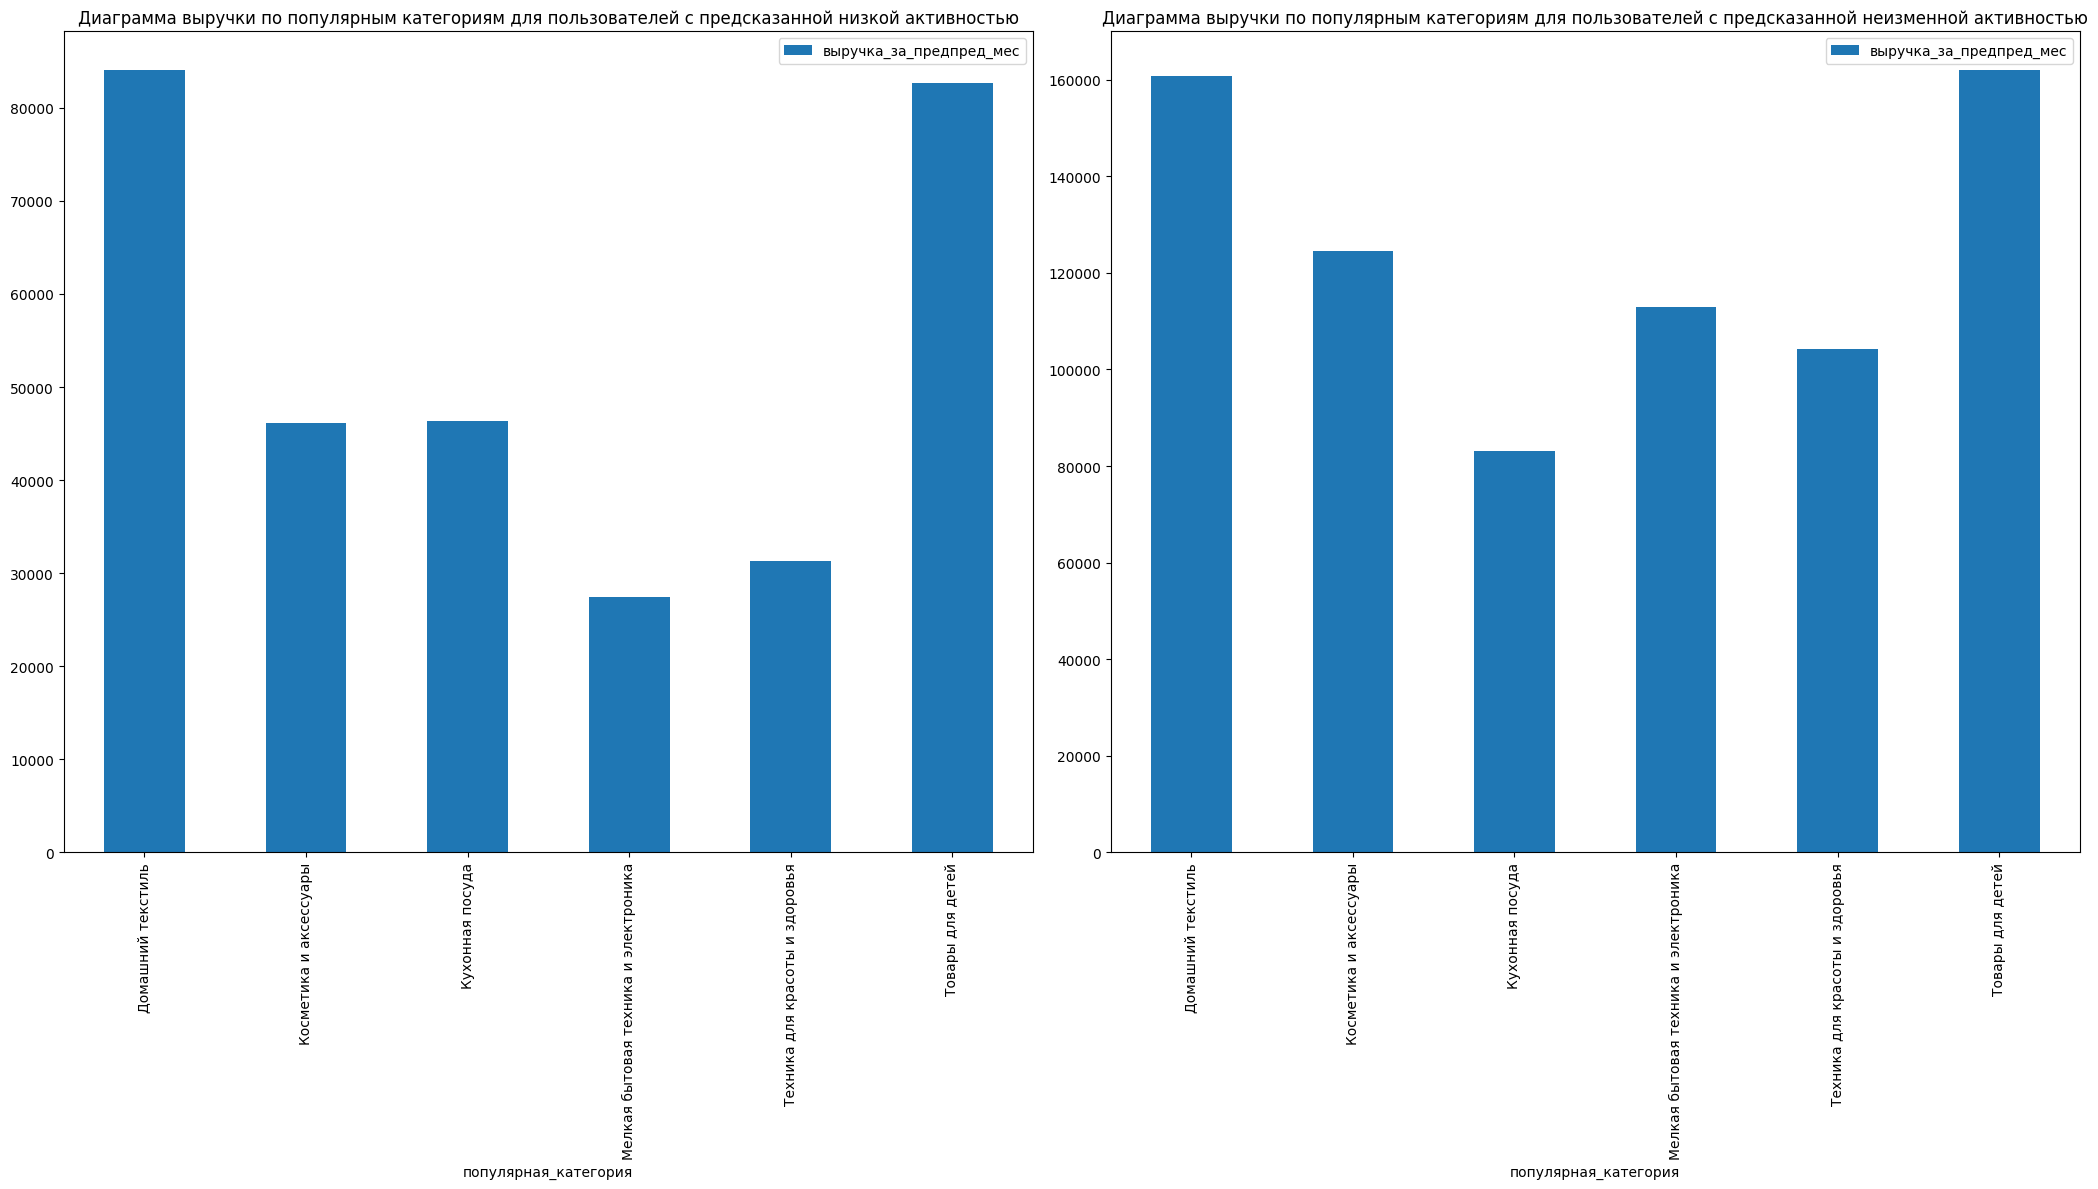

In [78]:
# Строим диаграмму выручки по популярным категориям для пользователей с предсказанной низкой активностью
# за предпредыдущий месяц
plt.subplot(1, 2, 1)
(
    X_test_middle_low_act.groupby('популярная_категория')['выручка_за_предпред_мес']
    .sum().plot(kind='bar', legend=True, figsize=(21, 12))
)
plt.title('Диаграмма выручки по популярным категориям для пользователей с предсказанной низкой активностью')
# Строим диаграмму выручки по популярным категориям для пользователей с предсказанной неизменной активностью
# за предпредыдущий месяц
plt.subplot(1, 2, 2)
(
    X_test_middle_curr_act.groupby('популярная_категория')['выручка_за_предпред_мес']
    .sum().plot(kind='bar', legend=True)
)
plt.title('Диаграмма выручки по популярным категориям для пользователей с предсказанной неизменной активностью')
plt.tight_layout()
plt.show()

* Из показанных распределений можно сделать вывод, что сегменты пользователей с малой и высокой прибыль мало интересуются бытовой техникой и техникой для красоты и здоровья.  
* Соотношения пользователей по остальным категориям в каждом сегменте похожи.

<a id='conclusion'></a>
## [Общий вывод](#start)

* Целью проекта является разработка модели, которая позволила бы предсказать покупательскую активность клиентов сервиса.  
* Исходные данные полные, названия столбцов были приведены к единому стилю. По необходимости был изменен тип данных в столбцах.
* Явных дубликатов и пропусков в данных обнаружено не было, названия категорий внутри столбцов были исправлены.
* Проведем корреляционный анализ данных, на его основании был сделан вывод об отсутствии мультиколлинеарности.
* Для поиска, лучше модели был разработам пайплайн с разными вариантами кодирования и масштабирования данных и четырьмя различными моделями. С помощью модуля GridSearchCV была выявлена модель с наиболее высоким показателем ROC-AUC.
* Это модель SVC c гиперпараметрами (C=1.5, gamma=0.1, probability=True, random_state=42)  
* По итогам моделирования и анализа сегментов покупателей, рекомендуется:
 * Обратить внимание, что пользователи, которые проводят меньше времени на сайте поо статистие более активно покупают продукты.
 * Увеличивать кол-во акций в категориях "кухонная посуда", "бытовая техника" и "техника для красоты и здоровья".